# Desafio DP6

**Nome**: Rafael Matheus G. Ribeiro

## Descrição da segunda parte
Já na segunda parte, é pedido que seja feito uma segmentação dos usuários de acordo com as semelhanças descritas pelos dados. 


## Import de bibliotecas

In [1]:
import pandas as pd
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import datetime
import nltk
import warnings
# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize, StandardScaler
from functools import reduce
from scipy.cluster.hierarchy import dendrogram
from sklearn.model_selection import train_test_split
# K-Means
from sklearn import cluster
from sklearn import preprocessing,metrics, feature_selection

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

## Machine Learning
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
## Descomente se não Houver baixado Anteriormente
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')

warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

<a id=’Funções’></a>
## Funções

In [2]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt
class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)




def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord


is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    countries_list = [line.rstrip('\n') for line in open('lists/countries.txt')] # Load .txt file line by line
    nationalities_list = [line.rstrip('\n') for line in open('lists/nationalities.txt')] # Load .txt file line by line
    other_words = [line.rstrip('\n') for line in open('lists/stopwords_scrapmaker.txt')] # Load .txt file line by line
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, countries_list)
        listOfTokens = removeWords(listOfTokens, nationalities_list)
        listOfTokens = removeWords(listOfTokens, other_words)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, other_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results
def run_AgglomerativeClustering(max_k,data):
    max_k += 1
    AC_results = dict()
    for k in range(2 , max_k):
        ac = cluster.AgglomerativeClustering(n_clusters = k)

        AC_results.update( {k : ac.fit(data)} )
        
    return AC_results
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Análise de Silhouette para K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Palvras mais comunus no Cluster {}".format(i)), fontsize=10, fontweight='bold')
        plt.grid()
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure(figsize=(12,6))
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()        

## Carregandos os dados

Algumas Informações sobbre a tabela

In [3]:
hits = pd.read_csv('analytics/hits.csv',low_memory= True) # Se False, temos problema de memória
session = pd.read_csv('analytics/sessions.csv',low_memory= True)
products = pd.read_csv('analytics/products.csv',low_memory= True)

#TODO implentar usando chunksize

Temos três tabelas, onde em comum temos as chaves: 
* FullVisitor: The unique visitor ID.
* visitId : An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.

Assim vamos, combinar as tabelas e assim teremos como identificar features em comuns entre os usuários que comparam um determinado produto, suas intereções e sessõs durate a compra.


In [4]:
# compile the list of dataframes you want to merge
data_frames = [hits, session, products]
data = reduce(lambda  left,right: pd.merge(left,right,on=['visitId','fullVisitorId'],
                                            how='inner'), data_frames)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8186258 entries, 0 to 8186257
Columns: 129 entries, dataSource to v2ProductName
dtypes: bool(2), float64(20), int64(17), object(90)
memory usage: 7.8+ GB


In [6]:
data.sample(5)

,dataSource,fullVisitorId,hitNumber_x,hour,isEntrance,isExit,isInteraction,latencyTracking,minute,promotion,...,productCouponCode,productListName,productListPosition,productPrice,productQuantity,productRevenue,productSKU,productVariant,v2ProductCategory,v2ProductName
1926000,web,5600144508443168160,1,7,True,NaN,True,NaN,27,[],...,NaN,Category,6,25990000,NaN,NaN,GGOEGXXX0885,(not set),Home/Apparel/Kid's/,Google Flower Onesie Purple
6095120,NaN,6359850382571142987,14,16,NaN,NaN,True,NaN,4,[],...,NaN,Category,16,18990000,NaN,NaN,GGOEGAAX0289,(not set),Home/Apparel/Women's/Women's-T-Shirts/,Google Women's Short Sleeve Shirt Dark Grey
4347060,web,3388110723290246024,34,3,NaN,NaN,True,NaN,28,[],...,NaN,Category,9,15990000,NaN,NaN,GGOEGOCL087799,(not set),Home/Office/,Google Large Standard Journal Navy
6575661,web,3573187621367839428,37,7,NaN,NaN,True,NaN,7,[],...,NaN,Category,6,119990000,NaN,NaN,GGOEGAAX0569,(not set),Home/Apparel/Men's/Men's-Performance Wear/,Google Men's Performance Full Zip Jacket Black
3597724,NaN,124850203340830679,40,13,NaN,NaN,True,NaN,55,[],...,NaN,(not set),0,43020000,NaN,NaN,GGOEGDHR018499,RED,Drinkware,Google 22 oz Water Bottle


## Analise Descritiva dos dados

In [7]:
data['fullVisitorId'] = data['fullVisitorId'].astype(str)

In [8]:
data.columns

Index(['dataSource', 'fullVisitorId', 'hitNumber_x', 'hour', 'isEntrance',
       'isExit', 'isInteraction', 'latencyTracking', 'minute', 'promotion',
       ...
       'productCouponCode', 'productListName', 'productListPosition',
       'productPrice', 'productQuantity', 'productRevenue', 'productSKU',
       'productVariant', 'v2ProductCategory', 'v2ProductName'],
      dtype='object', length=129)

In [9]:
# Formata a coluna date
data['date'] = data['date'].astype(str)
data['date'] = pd.to_datetime(data['date'],yearfirst=True,
                             format= "%Y/%m/%d")

In [10]:
data['date'].head(5)

0   2017-10-16
1   2017-10-16
2   2017-10-16
3   2017-10-16
4   2017-10-16
Name: date, dtype: datetime64[ns]

Filtrando usuarios que fizeram alguma transação

In [11]:
transaction = data['transaction_transactionId'].dropna()
idx = transaction.index
visitor_trans = data['fullVisitorId'].iloc[idx].unique() # usuarios que compraram algo
visitor = data['fullVisitorId'].unique()
visitor_Ntrans = np.setdiff1d(visitor,visitor_trans) # usuarios que não compraram algo
visitor_Ntrans.shape # ok

(8329,)

In [12]:
user = pd.DataFrame(columns=['user','NSessoes'])
user['user'] = visitor_trans

In [13]:
sess = []
for i in tqdm(range(len(visitor_trans))):
    count = len(data[data['fullVisitorId']==visitor_trans[i]]['visitId'].unique())
    sess.append(count)
user['NSessoes'] = sess


100%|██████████| 230/230 [01:18<00:00,  2.92it/s]


In [14]:
user.head()

,user,NSessoes
0,4716737341148415941,1
1,9291001063810206156,2
2,9851027407827249742,1
3,9549089852095378957,1
4,750845334721949296,1


In [15]:
print("A média de sessões abertas por usuários que fizeram alguma transação é %.2f"%(user['NSessoes'].mean()),
      " com desvio padram de %.2f" %(user['NSessoes'].std()))

A média de sessões abertas por usuários que fizeram alguma transação é 1.94  com desvio padram de 2.06


Vamos criar uma Coluna chamada Transaction, onde vamos atribuir valores $0$ e $1$.

Com um detalhe, vamos apenas atribuir esse valor na sessões onde o usuário realizou uma transação.

In [16]:
data["Transaction"] = 0 
for i in tqdm(range(len(visitor_trans))):

    if len(data[data['fullVisitorId']==visitor_trans[i]]['visitId'].unique()) >= 2:
        visitId = data[data['fullVisitorId']==visitor_trans[i]]['visitId'].unique()
        for j in visitId:
            if len(data[(data['fullVisitorId']==visitor_trans[i])&(data['visitId']==j)]['transaction_transactionId'].dropna().unique())> 0:
                data.loc[(data['fullVisitorId']==visitor_trans[i])&(data['visitId']==j),'Transaction'] = 1
            else:
                data.loc[(data['fullVisitorId']==visitor_trans[i])&(data['visitId']==j),'Transaction'] = 0
    else :
        data.loc[data['fullVisitorId']==visitor_trans[i],'Transaction']= 1                             
                         


100%|██████████| 230/230 [08:03<00:00,  2.10s/it]


In [17]:
data.sample(5)

,dataSource,fullVisitorId,hitNumber_x,hour,isEntrance,isExit,isInteraction,latencyTracking,minute,promotion,...,productListName,productListPosition,productPrice,productQuantity,productRevenue,productSKU,productVariant,v2ProductCategory,v2ProductName,Transaction
270877,NaN,560900418847852126,29,15,NaN,NaN,True,NaN,39,[],...,Category,6,109990000,NaN,NaN,GGOEGAAX0568,(not set),Home/Apparel/Men's/,Google Men's Watershed Full Zip Hoodie Grey,0
1689174,NaN,353619592852254769,28,10,NaN,NaN,True,NaN,19,[],...,Category,1,19990000,NaN,NaN,GGOEGAAX0680,(not set),Home/Apparel/Kid's/Kids-Youth/,Google Youth Baseball Raglan Heather/Black,0
6863893,web,2988379960019766803,11,13,NaN,NaN,True,NaN,23,[],...,Category,7,19190000,NaN,NaN,GGOEGDHT087199,(not set),Home/Drinkware/,Google Thermal Bottle Yellow,0
1416250,web,3806207761754253499,39,3,NaN,NaN,True,NaN,34,[],...,Search Results,4,16990000,NaN,NaN,GGOEGAAX0318,(not set),${escCatTitle},YouTube Men's Short Sleeve Hero Tee Black,0
4113355,web,334148642218717005,2,19,NaN,NaN,True,NaN,52,[],...,Related Products,2,0,NaN,NaN,9182785,(not set),(not set),Google Women's Lightweight Microfleece Jacket,0


In [18]:
session_trans = data[data['Transaction']==1]['visitId'].unique() # tabela de transações por sessão 
                                                                          

In [19]:
time = data[['fullVisitorId','time']].iloc[idx].drop_duplicates('fullVisitorId').copy()
time.head()

,fullVisitorId,time
9613,4716737341148415941,764873
68311,9291001063810206156,1078884
204141,9851027407827249742,656210
209145,9549089852095378957,971842
231476,750845334721949296,322699


## Visuzalização de dados

Text(0.5, 0, 'Tempo(milisegundos)')

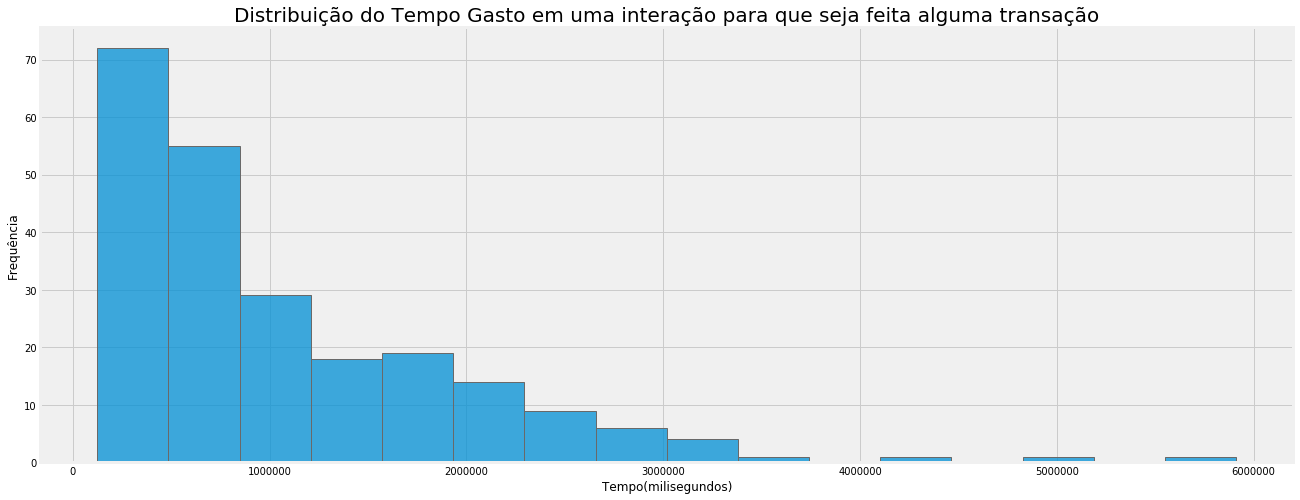

In [20]:
plt.rcParams['figure.figsize'] = (20, 8)
sns.histplot(time['time'],bins = 'auto',palette='rainbow')
plt.title('Distribuição do Tempo Gasto em uma interação para que seja feita alguma transação', fontsize = 20)
plt.ylabel("Frequência")
plt.xlabel("Tempo(milisegundos)")

Text(0.5, 0, 'No. de Sessões')

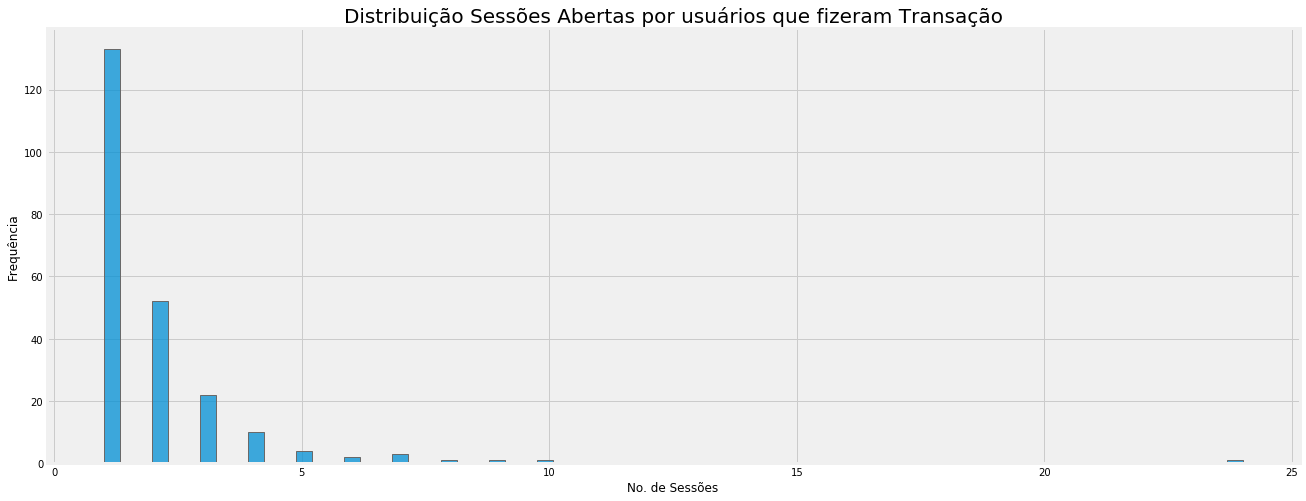

In [21]:
plt.rcParams['figure.figsize'] = (20, 8)
sns.histplot(user['NSessoes'],bins = 'auto',palette='rainbow')
plt.title('Distribuição Sessões Abertas por usuários que fizeram Transação', fontsize = 20)
plt.ylabel("Frequência")
plt.xlabel("No. de Sessões")

Text(0.5, 0, 'No. de Sessões')

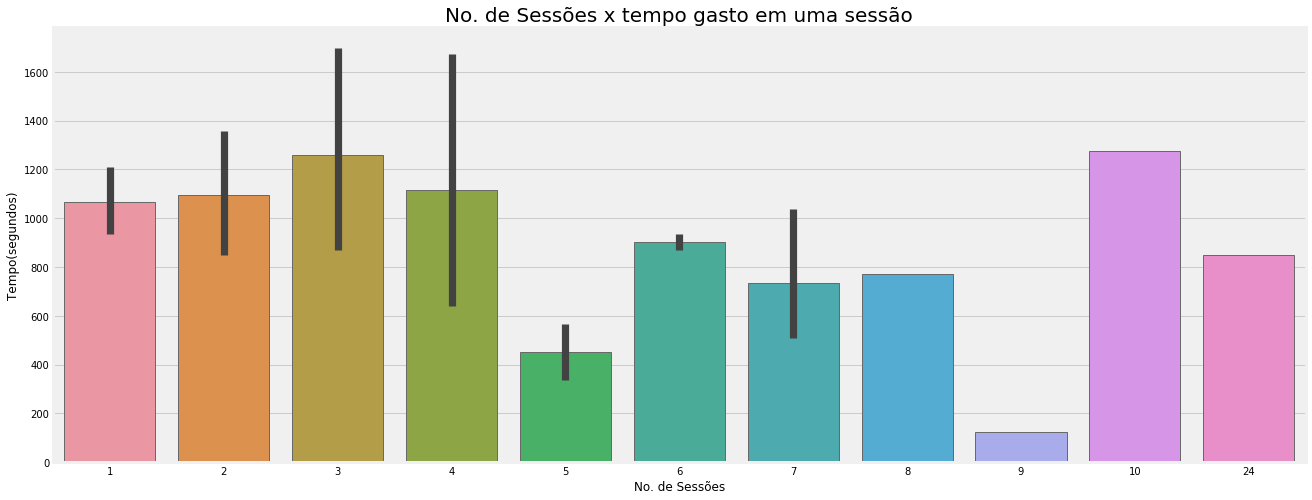

In [22]:
plt.rcParams['figure.figsize'] = (20, 8)
sns.barplot(user['NSessoes'].values,time['time'].values/1000)
plt.title('No. de Sessões x tempo gasto em uma sessão', fontsize = 20)
plt.ylabel("Tempo(segundos)")
plt.xlabel("No. de Sessões")

In [23]:
source = data["dataSource"].unique()
source


array(['web', nan, '(not set)'], dtype=object)

In [24]:
data['dataSource'].iloc[idx].value_counts()

web    24186
Name: dataSource, dtype: int64

In [25]:
data["dataSource"].fillna("(not set)",inplace = True) ## trocando NaN por not set
source = data["dataSource"].unique()
#source
visitors = [len(visitor_trans),len(visitor_Ntrans)] # visitantes que compraram algo
#visitorsTrans

Text(0.5, 1.0, 'Distribuição de Compras por Usuário \n (230.0 || 8329.0)')

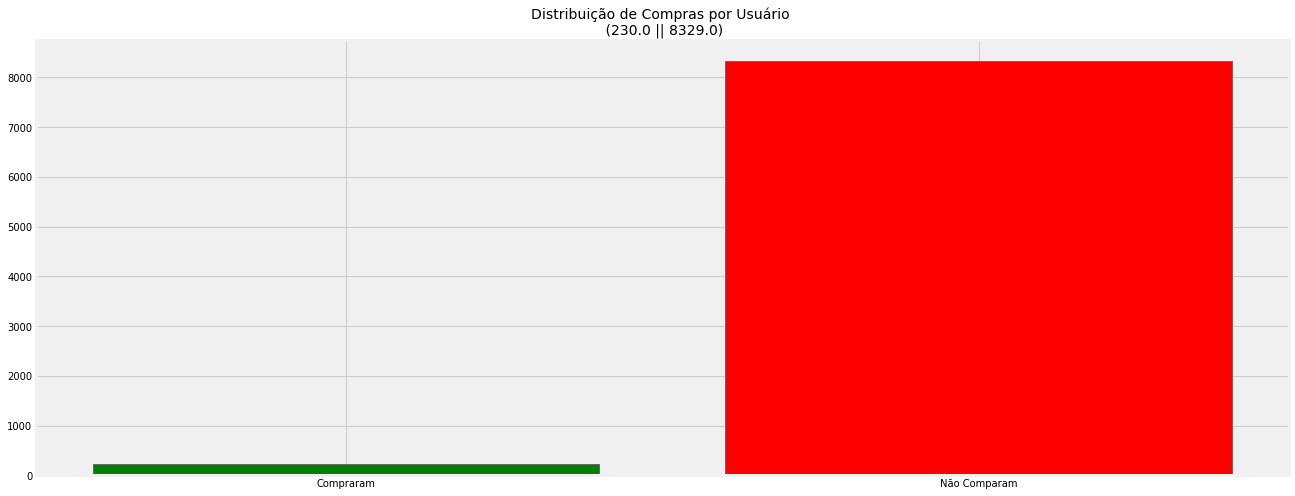

In [26]:
plt.rcParams['figure.figsize'] = (20, 8)
plt.bar(['Compraram','Não Comparam'],visitors, color= ['green','r'])
plt.title('Distribuição de Compras por Usuário \n (230.0 || 8329.0)', fontsize = 14)

In [27]:
source_trans = data[data['visitId'].isin(session_trans)][['dataSource','visitId']].drop_duplicates('visitId')


Text(0.5, 1.0, 'Distribuição de Compras por Plataforma ')

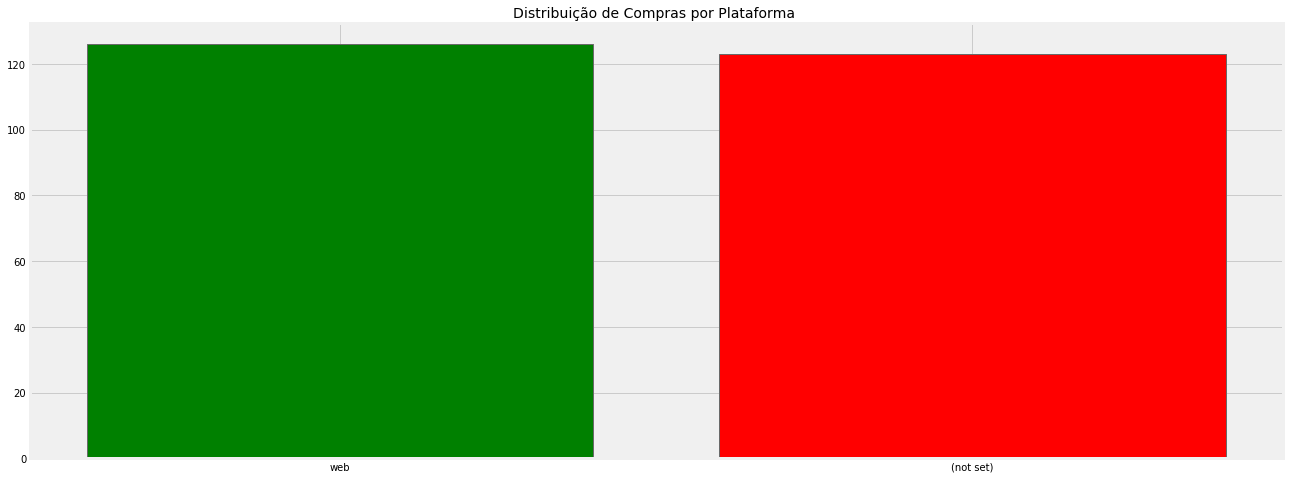

In [28]:
plt.rcParams['figure.figsize'] = (20, 8)
plt.bar(source,source_trans['dataSource'].value_counts(), color= ['green','r'])
plt.title('Distribuição de Compras por Plataforma ', fontsize = 14)

Está bem Distruibuída

Text(0.5, 0, 'Visualizações por sessão')

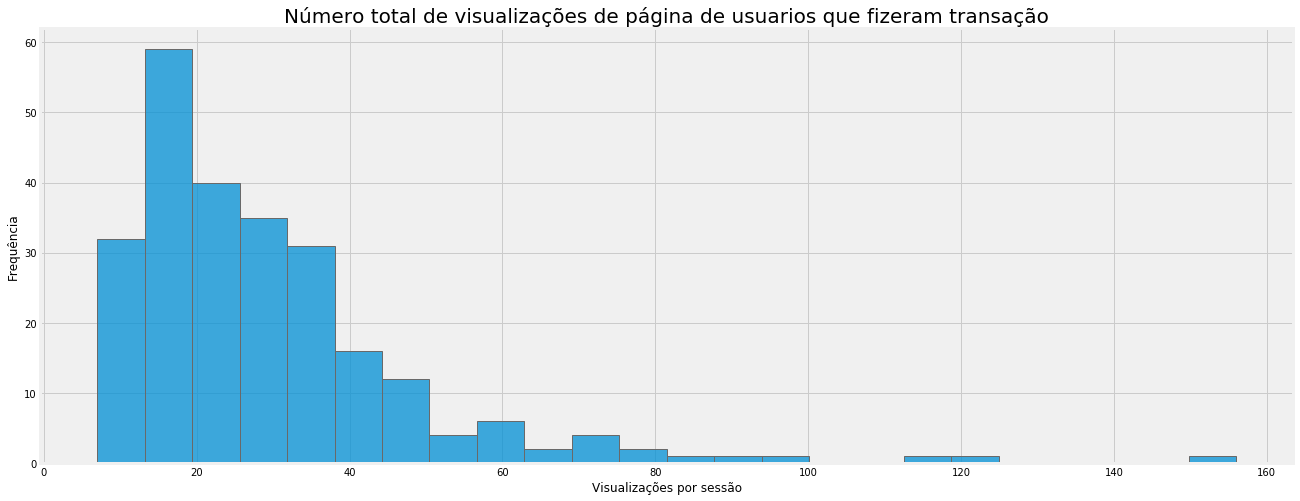

In [29]:
pageV = data[data['Transaction']==1][['visitId','totals_pageviews',]].drop_duplicates('visitId')

plt.rcParams['figure.figsize'] = (20, 8)
sns.histplot(pageV['totals_pageviews'],bins = 'auto',palette='rainbow')
plt.title('Número total de visualizações de página de usuarios que fizeram transação', fontsize = 20)
plt.ylabel("Frequência")
plt.xlabel("Visualizações por sessão")

Text(0.5, 0, 'Receita por sessão')

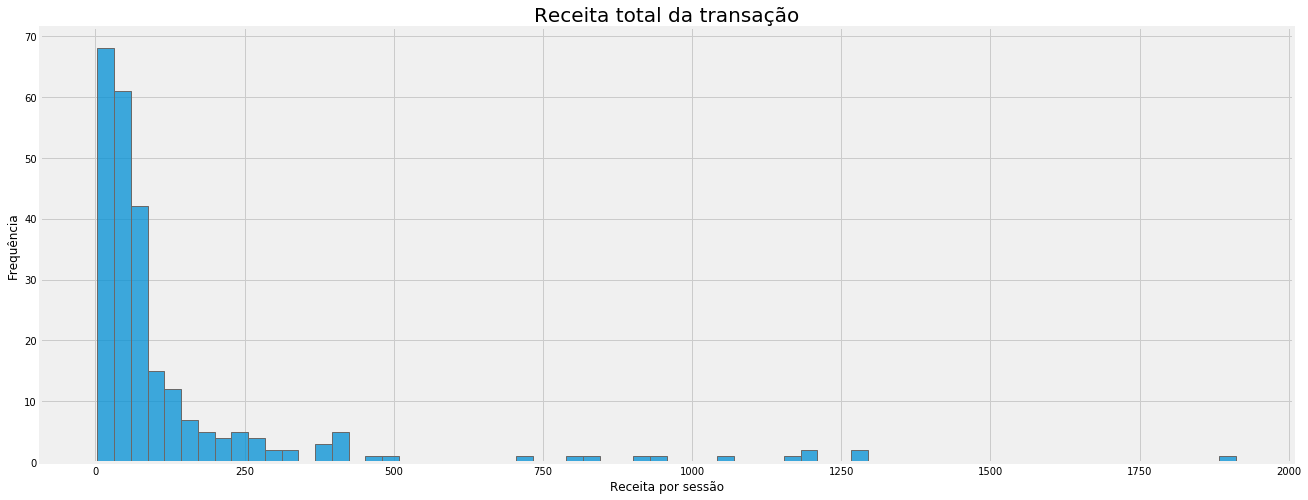

In [30]:
trans = data[data['Transaction']==1][['visitId','totals_transactionRevenue']].drop_duplicates('visitId')

plt.rcParams['figure.figsize'] = (20, 8)
sns.histplot(trans['totals_transactionRevenue'].values/1e6,bins = 'auto',palette='rainbow')
plt.title('Receita total da transação', fontsize = 20)
plt.ylabel("Frequência")
plt.xlabel("Receita por sessão")

Text(0.5, 0, 'Preços')

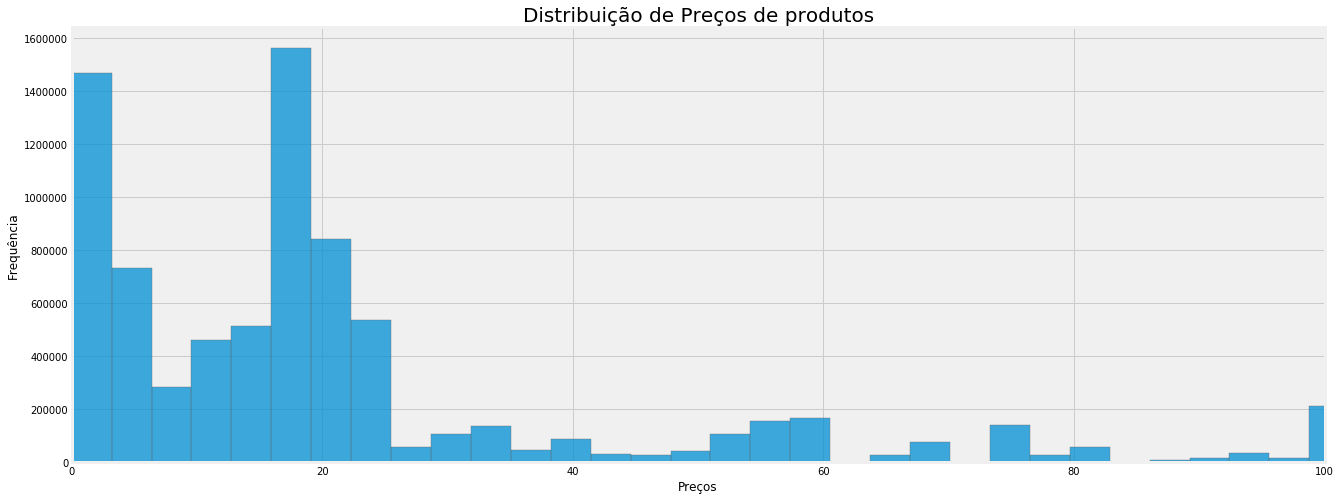

In [31]:
plt.rcParams['figure.figsize'] = (20, 8)
sns.histplot(data['productPrice'].values/1e6,bins = 300,palette='rainbow')
plt.title('Distribuição de Preços de produtos', fontsize = 20)
plt.ylabel("Frequência")
plt.xlim(0,100)
plt.xlabel("Preços")

In [32]:
time = data[['geoNetwork_country','totals_timeOnSite','visitId','totals_pageviews','social_socialNetwork','device_deviceCategory','device_browser','geoNetwork_continent','date','productPrice','channelGrouping']].drop_duplicates('visitId')
time.drop('visitId',axis = 1 ,inplace = True)
time = time.sort_values(by = 'date')
time.head(5)

,geoNetwork_country,totals_timeOnSite,totals_pageviews,social_socialNetwork,device_deviceCategory,device_browser,geoNetwork_continent,date,productPrice,channelGrouping
6120762,Netherlands,56.0,3.0,(not set),desktop,Safari,Europe,2016-08-03,990000,Direct
6139799,United States,135.0,11.0,(not set),desktop,Chrome,Americas,2016-08-03,3500000,Organic Search
6276923,United States,NaN,1.0,(not set),tablet,Safari,Americas,2016-08-03,3500000,Direct
6276937,Egypt,NaN,1.0,(not set),desktop,Chrome,Africa,2016-08-03,3500000,Organic Search
6276951,United States,NaN,1.0,(not set),mobile,Chrome,Americas,2016-08-03,16990000,Organic Search


Text(0.5, 0, 'Preço de Produto')

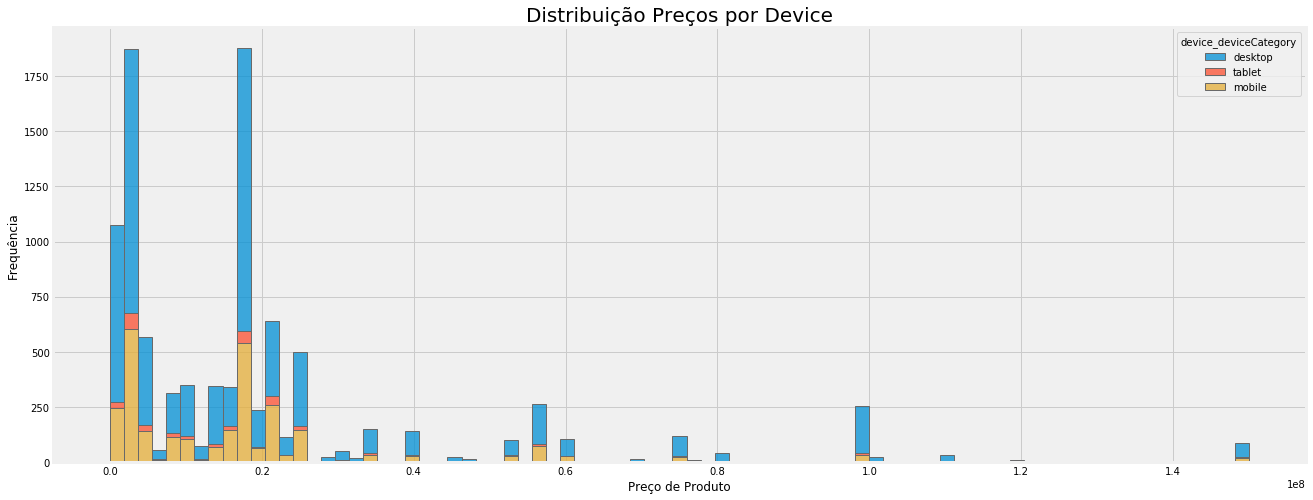

In [33]:
plt.title('Distribuição Preços por Device', fontsize = 20)
sns.histplot(data = time,x = 'productPrice' , hue = 'device_deviceCategory', bins = 'auto', multiple='stack' )
plt.ylabel("Frequência")
plt.xlabel("Preço de Produto")

Text(0.5, 0, 'Tempo(s)')

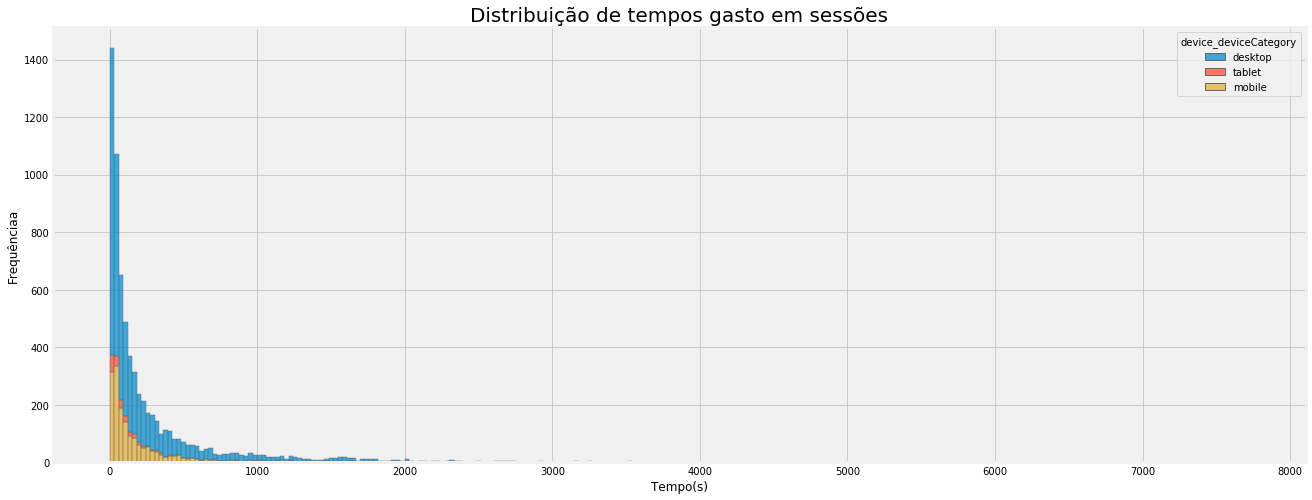

In [34]:
plt.title('Distribuição de tempos gasto em sessões', fontsize = 20)
sns.histplot(data = time,x = 'totals_timeOnSite' , hue = 'device_deviceCategory', bins = 'auto', multiple='stack' )
plt.ylabel("Frequênciaa")
plt.xlabel("Tempo(s)")

Text(0.5, 0, 'Visualizações')

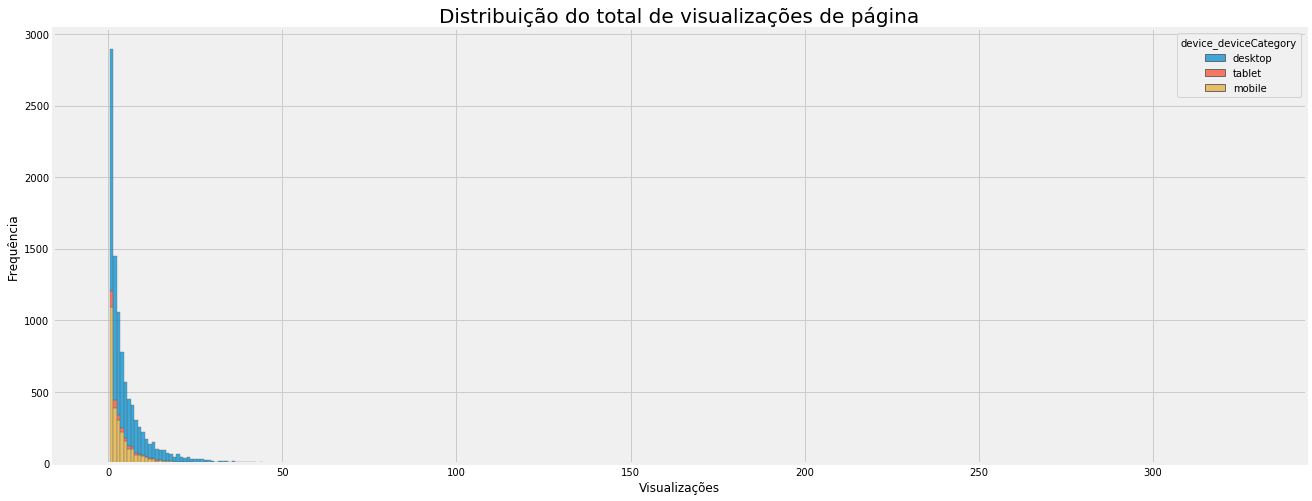

In [35]:
plt.title('Distribuição do total de visualizações de página', fontsize = 20)
sns.histplot(data = time,x = 'totals_pageviews' , hue = 'device_deviceCategory', bins = 'auto', multiple='stack',discrete = True )
plt.ylabel("Frequência")
plt.xlabel("Visualizações")

Text(0.5, 0, 'Preço de Produto')

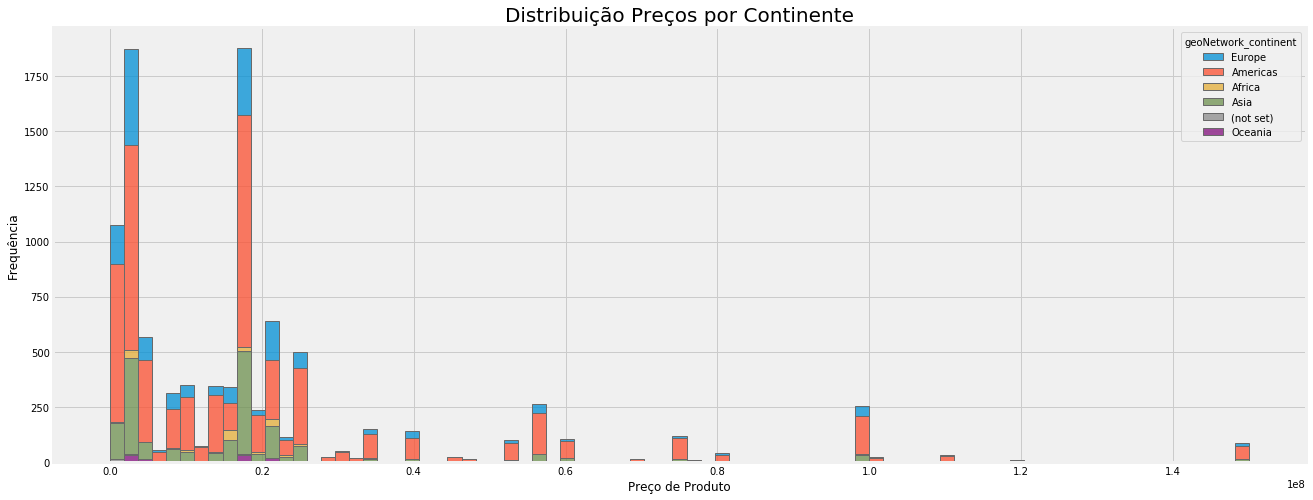

In [36]:
plt.title('Distribuição Preços por Continente', fontsize = 20)
sns.histplot(data = time,x = 'productPrice' , hue = 'geoNetwork_continent', bins = 'auto', multiple='stack' )
plt.ylabel("Frequência")
plt.xlabel("Preço de Produto")

Text(0.5, 0, 'Tempo(s)')

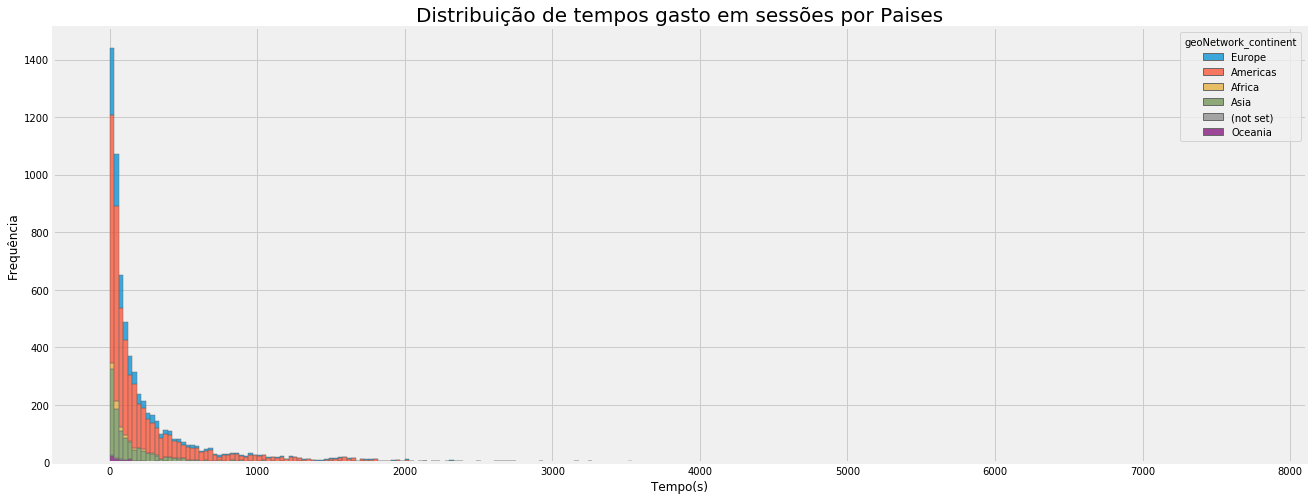

In [37]:
plt.title('Distribuição de tempos gasto em sessões por Paises', fontsize = 20)
sns.histplot(data = time,x = 'totals_timeOnSite' , hue = 'geoNetwork_continent', bins = 'auto', multiple='stack' )
plt.ylabel("Frequência")
plt.xlabel("Tempo(s)")

Text(0.5, 0, 'Visualizações')

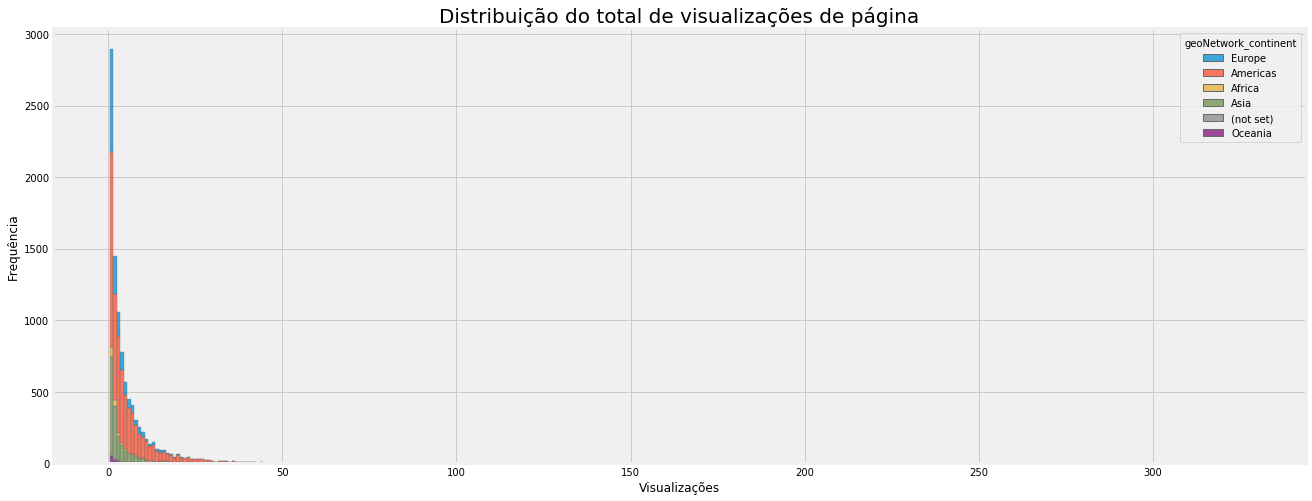

In [38]:
plt.title('Distribuição do total de visualizações de página', fontsize = 20)
sns.histplot(data = time,x = 'totals_pageviews' , hue = 'geoNetwork_continent', bins = 'auto', multiple='stack',discrete = True )
plt.ylabel("Frequência")
plt.xlabel("Visualizações")

Text(0, 0.5, 'Frequência')

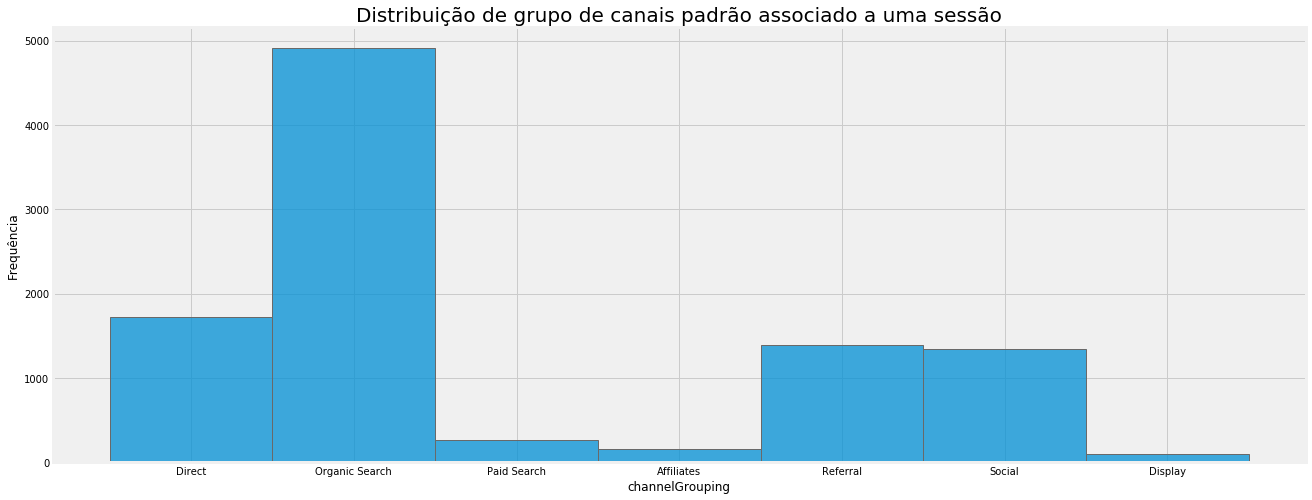

In [39]:
plt.title('Distribuição de grupo de canais padrão associado a uma sessão', fontsize = 20)
sns.histplot(data = time,x = 'channelGrouping' , bins = 'auto', multiple='stack',discrete = True)
plt.ylabel("Frequência")

Text(0, 0.5, 'Frequência')

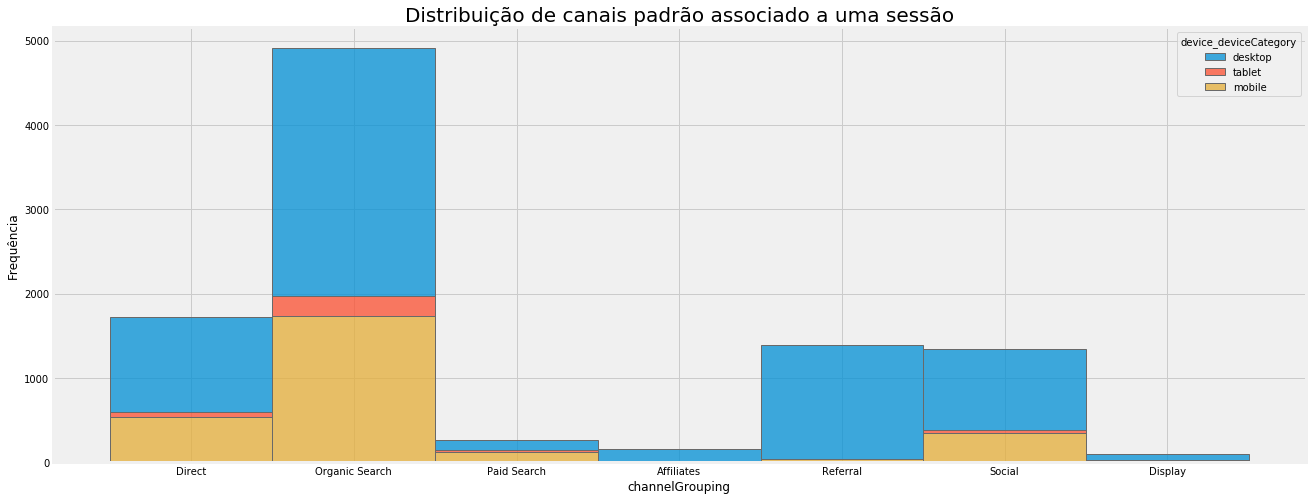

In [40]:
plt.title('Distribuição de canais padrão associado a uma sessão', fontsize = 20)
sns.histplot(data = time,x = 'channelGrouping' , hue = 'device_deviceCategory', bins = 'auto', multiple='stack',discrete = True)
plt.ylabel("Frequência")

Text(0, 0.5, 'Frequência')

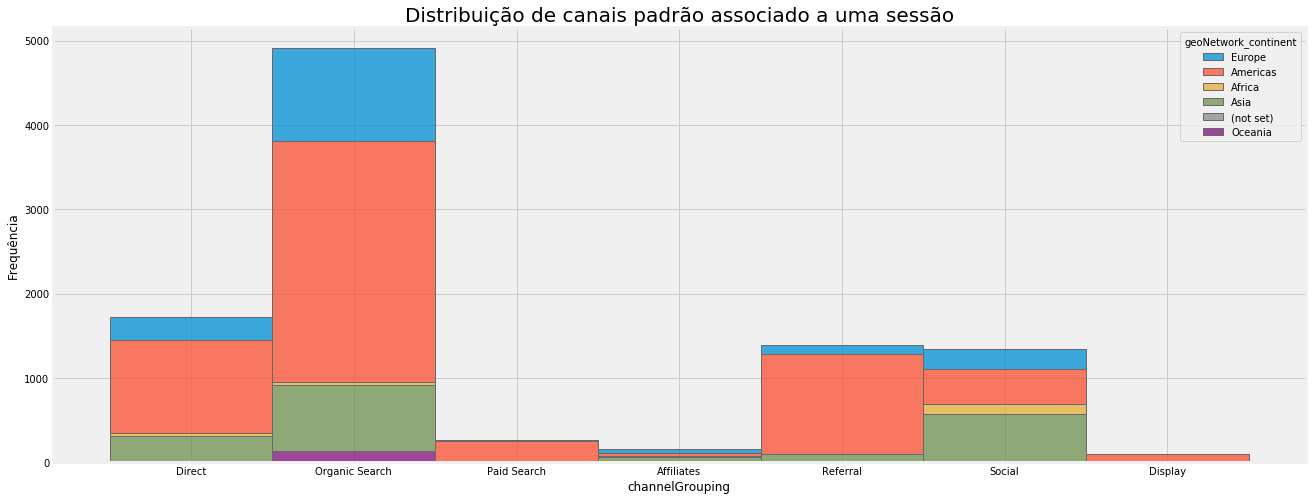

In [41]:
plt.title('Distribuição de canais padrão associado a uma sessão', fontsize = 20)
sns.histplot(data = time,x = 'channelGrouping' , hue = 'geoNetwork_continent', bins = 'auto', multiple='stack',discrete = True)
plt.ylabel("Frequência")

Text(0, 0.5, 'Frequência')

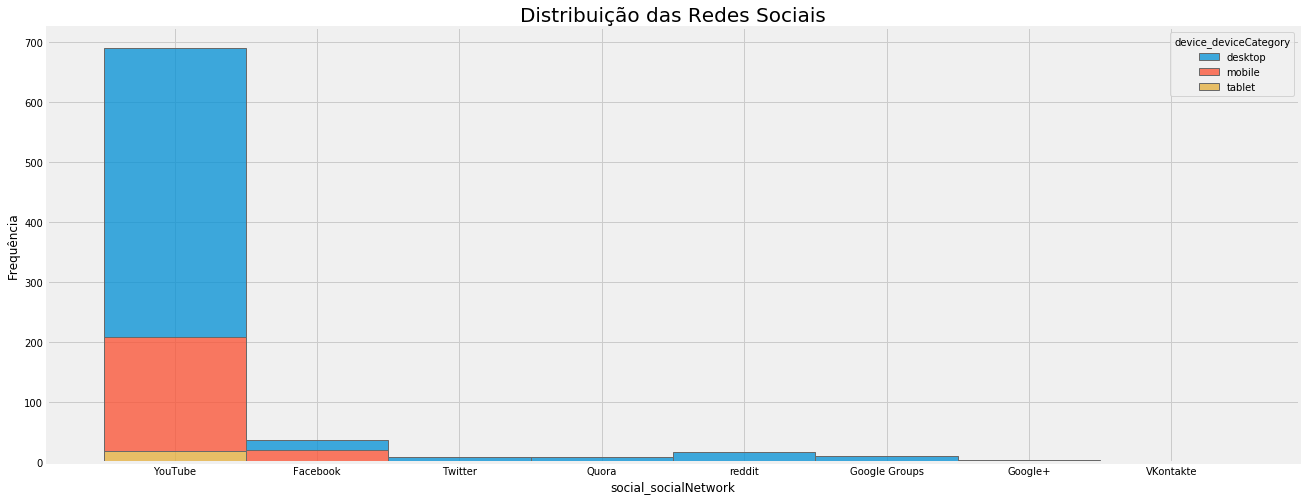

In [42]:
time['social_socialNetwork'] = time['social_socialNetwork'].replace('(not set)', np.nan)
time.dropna(inplace = True)
plt.title('Distribuição das Redes Sociais', fontsize = 20)
sns.histplot(data = time,x = 'social_socialNetwork' , hue = 'device_deviceCategory', bins = 'auto', multiple='stack',discrete = True)
plt.ylabel("Frequência")

Text(0, 0.5, 'Frequência')

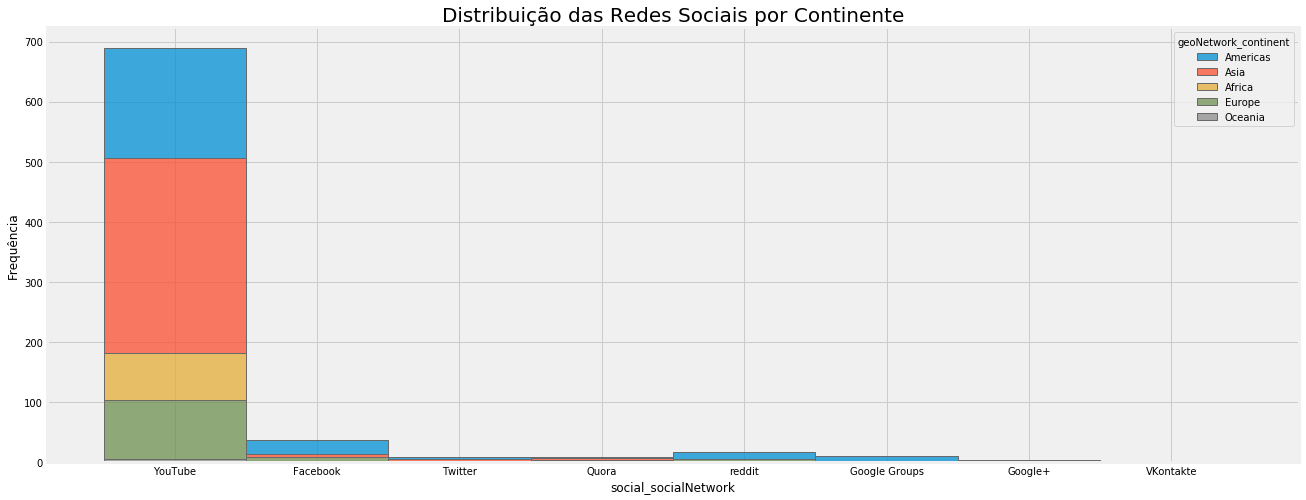

In [43]:
time['geoNetwork_continent'] = time['geoNetwork_continent'].replace('(not set)', np.nan)
time.dropna(inplace = True)
plt.title('Distribuição das Redes Sociais por Continente', fontsize = 20)
sns.histplot(data = time,x = 'social_socialNetwork' , hue = 'geoNetwork_continent', bins = 'auto', multiple='stack',discrete = True)
plt.ylabel("Frequência")

**Algumas informações extras sobre promoções em paginas**

In [44]:
# Viu a promoção e realziou tansação
user = []
n_user = []
promoV = data[['fullVisitorId','visitId','promotionActionInfo_promoIsView','Transaction']].copy()
#promoV = promoV[promoV['Transaction']==1]
for i in tqdm(range(len(visitor_trans))):
    sess = len(promoV[promoV["fullVisitorId"]==visitor_trans[i]]['visitId'].unique())
    trans = len(promoV[promoV["fullVisitorId"]==visitor_trans[i]]['Transaction'].unique())
    promo = len(promoV[promoV["fullVisitorId"]==visitor_trans[i]]['promotionActionInfo_promoIsView'].unique())
    if promo == 2 & trans ==2:
        user.append({'user':visitor_trans[i],'Sessões Abertas' :sess, 'Comprou algo': 'Sim', 'Promo vista':'Sim','interações':len(promoV[promoV["fullVisitorId"]==visitor_trans[i]]['fullVisitorId']) })

    else:
        n_user.append({'user':visitor_trans[i],'Sessões Abertas' :sess, 'Comprou algo': 'Sim', 'Promo vista':'Não','interações':len(promoV[promoV["fullVisitorId"]==visitor_trans[i]]['fullVisitorId'])})



100%|██████████| 230/230 [04:57<00:00,  1.30s/it]


In [45]:
print('Pessoas que viram uma promoção e comparam', round(len(user)/(len(user)+len(n_user)) * 100,2), '% ')
print('Pessoas que não viram uma promoção e comparam', round(len(n_user)/(len(user)+len(n_user)) * 100,2), '%')

Pessoas que viram uma promoção e comparam 37.39 % 
Pessoas que não viram uma promoção e comparam 62.61 %


In [46]:
## Clicou a promoção e comprou
user = []
n_user = []
promoC = data[['fullVisitorId','visitId','promotionActionInfo_promoIsClick','Transaction']].copy()
for i in tqdm(range(len(visitor_trans))):
    sess = len(promoC[promoC["fullVisitorId"]==visitor_trans[i]]['visitId'].unique())
    trans = len(promoC[promoC["fullVisitorId"]==visitor_trans[i]]['Transaction'].unique())
    promo = len(promoC[promoC["fullVisitorId"]==visitor_trans[i]]['promotionActionInfo_promoIsClick'].unique())
    if promo == 2 & trans ==2:
        user.append({'user':visitor_trans[i],'Sessões Abertas' :sess, 'Comprou algo': 'Sim', 'Promo clicada':'Sim','interações':len(promoV[promoV["fullVisitorId"]==visitor_trans[i]]['fullVisitorId'])})

    else:
        n_user.append({'user':visitor_trans[i],'Sessões Abertas' :sess, 'Comprou algo': 'Sim', 'Promo clicada':'Não','interações':len(promoV[promoV["fullVisitorId"]==visitor_trans[i]]['fullVisitorId'])})



100%|██████████| 230/230 [05:02<00:00,  1.31s/it]


In [47]:
print('Pessoas que clicaram e comparam', round(len(user)/(len(user)+len(n_user)) * 100,2), '% ')
print('Pessoas que não clicara e comparam', round(len(n_user)/(len(user)+len(n_user)) * 100,2), '%')

Pessoas que clicaram e comparam 4.35 % 
Pessoas que não clicara e comparam 95.65 %


Nb of keywords in variable 'Description': 51


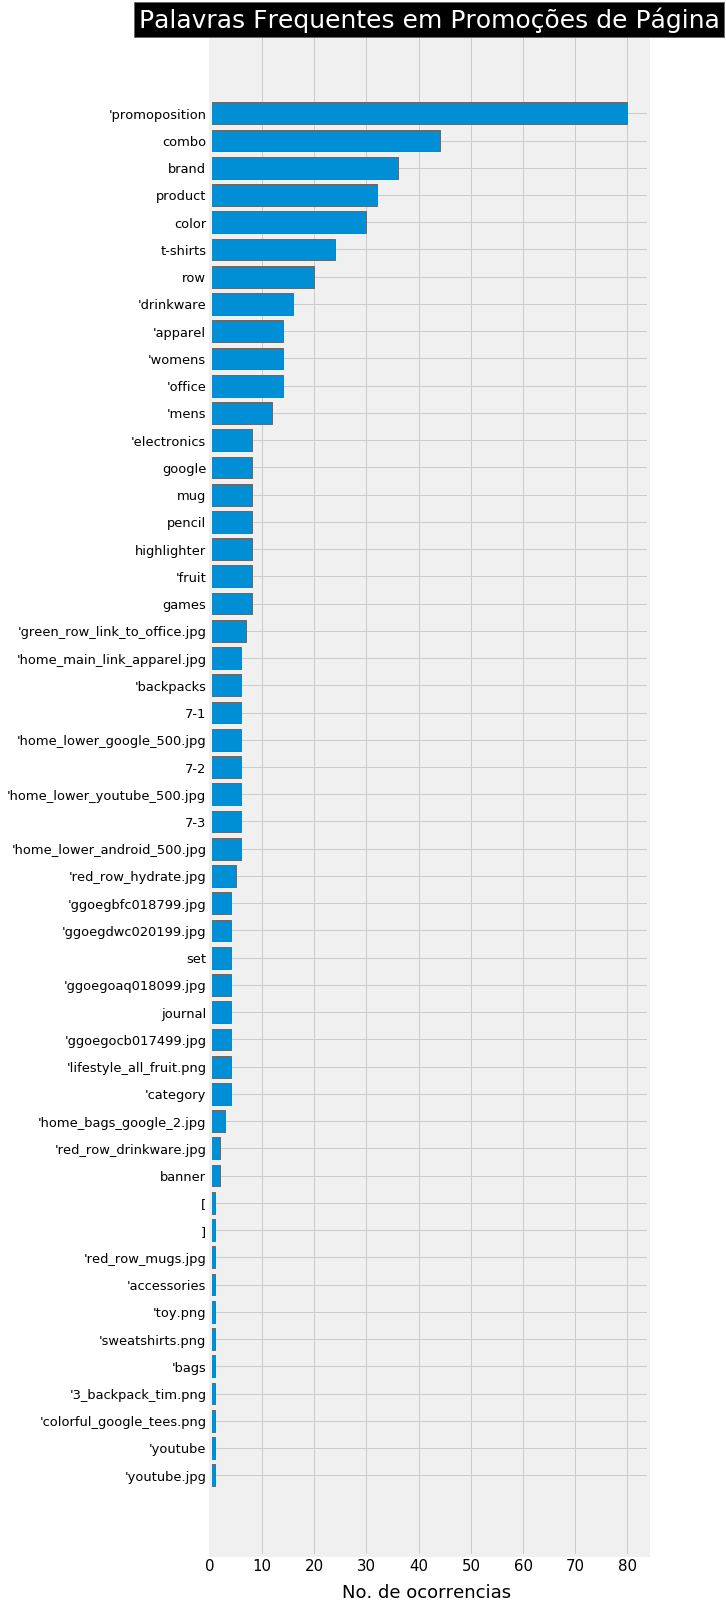

In [48]:
promo = pd.DataFrame(data['promotion'].unique()).rename(columns = {0:'Description'})
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(promo)
list_promo = []
for k,v in count_keywords.items():
    list_promo.append([keywords_select[k],v])
list_promo.sort(key = lambda x:x[1], reverse = True)
liste = sorted(list_promo, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 28))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("No. de ocorrencias ", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Palavras Frequentes em Promoções de Página",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

## Agrupamentos

Agora, vamos usar o algoritmo k-means, um algoritmo de agrupamento simples e popular não supervisionado, para agrupar palavras e depois produtos dentro do nosso dataset.

O objetivo do K-means é simples: agrupar pontos de dados semelhantes e descobrir padrões subjacentes. Para atingir este objetivo, K-means procura um número fixo definido (k) de centróides em um conjunto de dados. Um centróide se refere a um cluster, que é uma coleção de pontos de dados agregados devido a certas semelhanças entre si. O "meio" no K-meio refere-se à média dos dados; ou seja, encontrar o centróide. E o algoritmo é dito não supervisionado porque não temos conhecimento prévio a respeito dos grupos ou classes de nosso conjunto de dados, ou seja, encontraremos os grupos subjacentes em nosso conjunto de dados.

In [49]:
x = data[data['fullVisitorId'].isin(visitor_trans)].copy()
x.sample(5)

,dataSource,fullVisitorId,hitNumber_x,hour,isEntrance,isExit,isInteraction,latencyTracking,minute,promotion,...,productListName,productListPosition,productPrice,productQuantity,productRevenue,productSKU,productVariant,v2ProductCategory,v2ProductName,Transaction
5309153,(not set),3835134197841326255,25,7,NaN,NaN,True,NaN,54,[],...,(not set),0,2990000,20.0,NaN,GGOEAFKQ020599,(not set),Home/Accessories/Stickers/,Android Sticker Sheet Ultra Removable,0
4842571,(not set),2086102344648063828,104,14,NaN,NaN,True,NaN,9,[],...,Related Products,3,0,NaN,NaN,9182785,(not set),(not set),Google Women's Lightweight Microfleece Jacket,1
5422649,web,1116962533790637551,74,19,NaN,NaN,True,NaN,9,[],...,Category,7,13990000,NaN,NaN,GGOEGDHR082199,(not set),Home/Drinkware/Water Bottles and Tumblers/,Google 25 oz Red Stainless Steel Bottle,0
2043380,(not set),5759286550067943008,27,6,NaN,NaN,True,NaN,18,[],...,Category,25,15190000,NaN,NaN,GGOEGAAX0324,(not set),Home/Apparel/Men's/Men's-T-Shirts/,Android Men's Short Sleeve Tri-blend Hero Tee ...,1
7972256,(not set),1814166460229302850,43,7,NaN,NaN,True,NaN,56,[],...,Category,1,3990000,NaN,NaN,GGOEAKDH019899,(not set),Home/Accessories/,Windup Android,1


### Text Clustering

Vamos Primeiro agrupar texto, onde irá conter 
1. Promoções
2. Conteudo da Pagina e Sites
3. Tipos de Aparalho
4. Rede sociais
5. Eventos
6. Produtos em Gerais

Para isso Vamos usar algumas colunas de texto do nosso dataset e extrair palavras

#### Processamento de Corpus
1. Stop Words e Stemming

    Faremos uma rotina de engenharia de dados com nosso dataset para mais tarde podermos fazer um bom modelo estatístico. Para isso, removeremos todas as palavras que não contribuem para o significado semântico do texto (palavras que não estão no alfabeto inglês) e manteremos todas as palavras restantes no formato mais simples possível, para que possamos aplique uma função que dê pesos a cada palavra sem gerar qualquer tendência ou outliers. Para isso, existem várias técnicas de limpeza do nosso corpus, entre elas removeremos as palavras mais comuns (palavras de interrupção) e aplicaremos o stemming, técnica que reduz uma palavra à sua raiz.

    Os métodos que aplicam a remoção de lematização e stop words estão listados abaixo. Também definiremos um método que remove quaisquer palavras com menos de 2 letras ou mais de 21 letras para limpar ainda mais o nosso corpus.


Todas as funções estão definidas [aqui](#Funções)

In [50]:
words = pd.DataFrame(x['eventInfo_eventLabel'].unique()).rename(columns = {0:'Description'})

words = words.append(pd.DataFrame(x['contentGroup_contentGroup3'].unique()).rename(columns = {0:'Description'}),ignore_index = True)
words = words.append(pd.DataFrame(x['contentGroup_contentGroup1'].unique()).rename(columns = {0:'Description'}),ignore_index = True)
words = words.append(pd.DataFrame(x['contentGroup_contentGroup2'].unique()).rename(columns = {0:'Description'}),ignore_index = True)
words = words.append(pd.DataFrame(x['promotion'].unique()).rename(columns = {0:'Description'}),ignore_index = True)
words = words.append(pd.DataFrame(x['page_pageTitle'].unique()).rename(columns = {0:'Description'}),ignore_index = True)
words = words.append(pd.DataFrame(x['v2ProductName'].unique()).rename(columns = {0:'Description'}),ignore_index = True)
words = words.append(pd.DataFrame(x['v2ProductCategory'].unique()).rename(columns = {0:'Description'}),ignore_index = True)
words = words.append(pd.DataFrame(x['geoNetwork_continent'].unique()).rename(columns = {0:'Description'}),ignore_index = True)
words = words.append(pd.DataFrame(x['geoNetwork_country'].unique()).rename(columns = {0:'Description'}),ignore_index = True)
words = words.append(pd.DataFrame(x['device_deviceCategory'].unique()).rename(columns = {0:'Description'}),ignore_index = True)


words.dropna(inplace = True)
words.head()
                    

,Description
1,Google Women's Scoop Neck Tee Black
2,Google Women's Scoop Neck Tee White
3,Google Women's Recycled Fabric Tee
4,Google Women's Short Sleeve Hero Tee Sky Blue
5,Google Women's Short Sleeve Hero Dark Grey


In [51]:
words_list = words['Description'].to_list()

In [52]:
corpus = processCorpus(words_list, 'english')


#### Estatística de Palavras
Agora, vamos aplicar a função TF-IDF, abreviação de termo frequência inversa frequência de documento, que é uma estatística numérica destinada a refletir a importância de uma palavra para um documento em um corpus, atribuindo a cada palavra em um documento uma pontuação que varia de 0 a 1.

In [53]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)


1326 rows


,0,1,2,3,4,5,6,7,8,9,...,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325
scoop,0.633436,0.608759,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
neck,0.543778,0.522594,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
black,0.329615,0.000000,0.000000,0.000000,0.000000,0.0,0.361908,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
women,0.312459,0.300287,0.306155,0.284349,0.307819,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tee,0.259511,0.249402,0.254276,0.236165,0.000000,0.0,0.000000,0.300784,0.295698,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


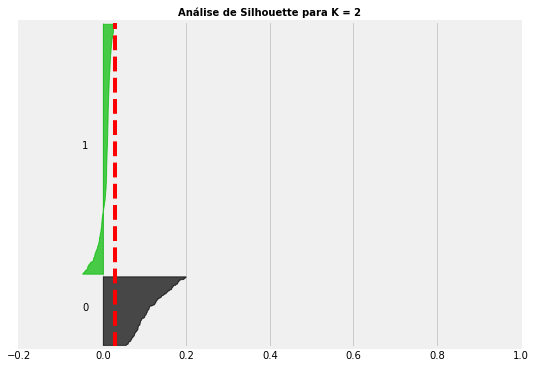

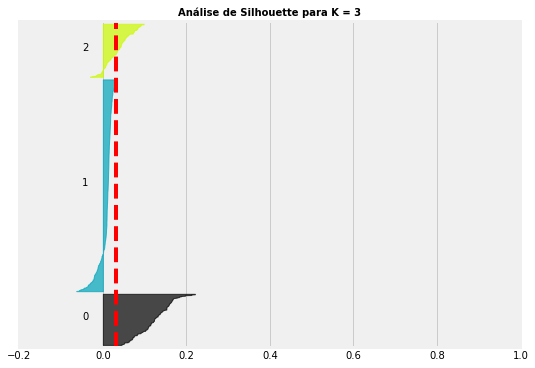

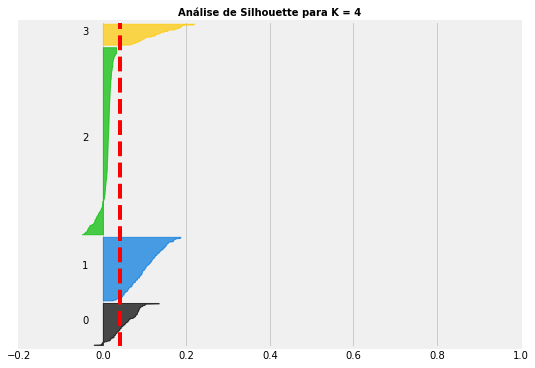

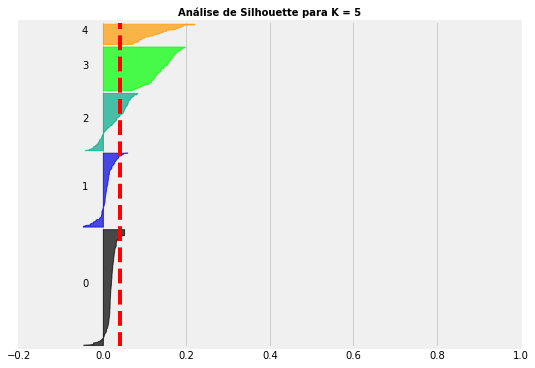

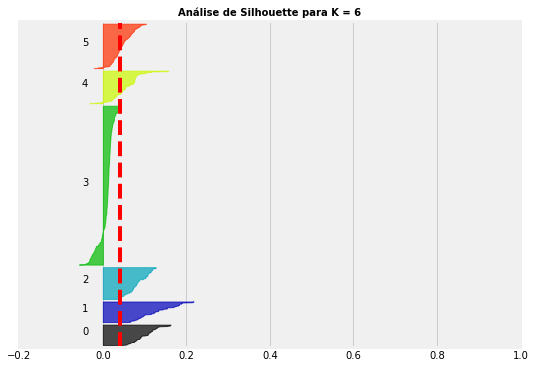

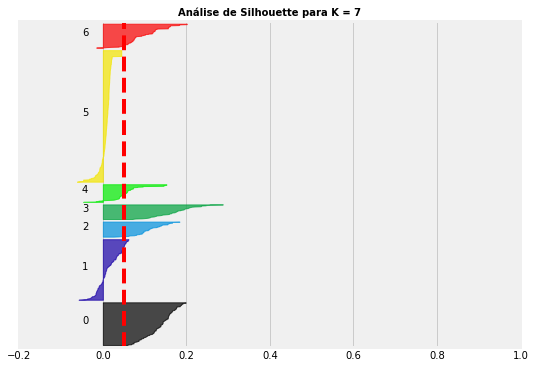

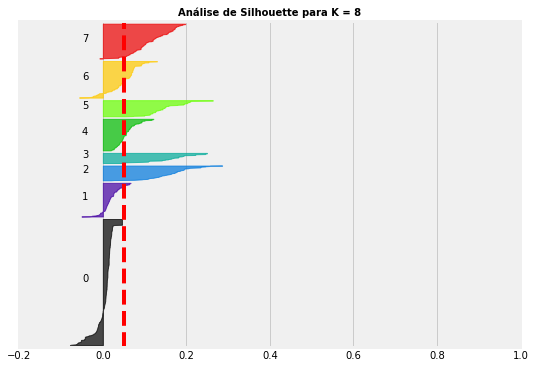

In [54]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
silhouette(kmeans_results, final_df, plot=True)

#### Análise de Cluster
Agora podemos escolher o melhor número de K e dar uma olhada mais profunda em cada cluster. Olhando para os gráficos acima, temos algumas pistas de que quando K = 5 é quando os clusters estão mais bem definidos. Portanto, primeiro usaremos um histograma simples para observar as palavras mais dominantes em cada cluster:

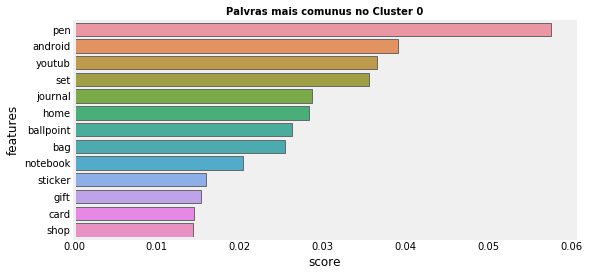

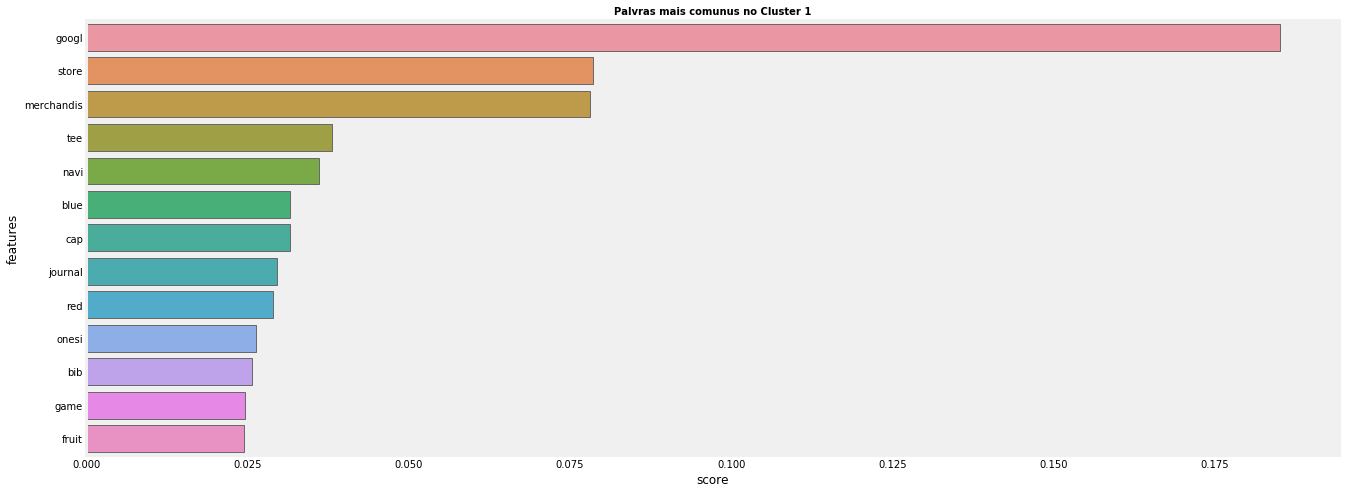

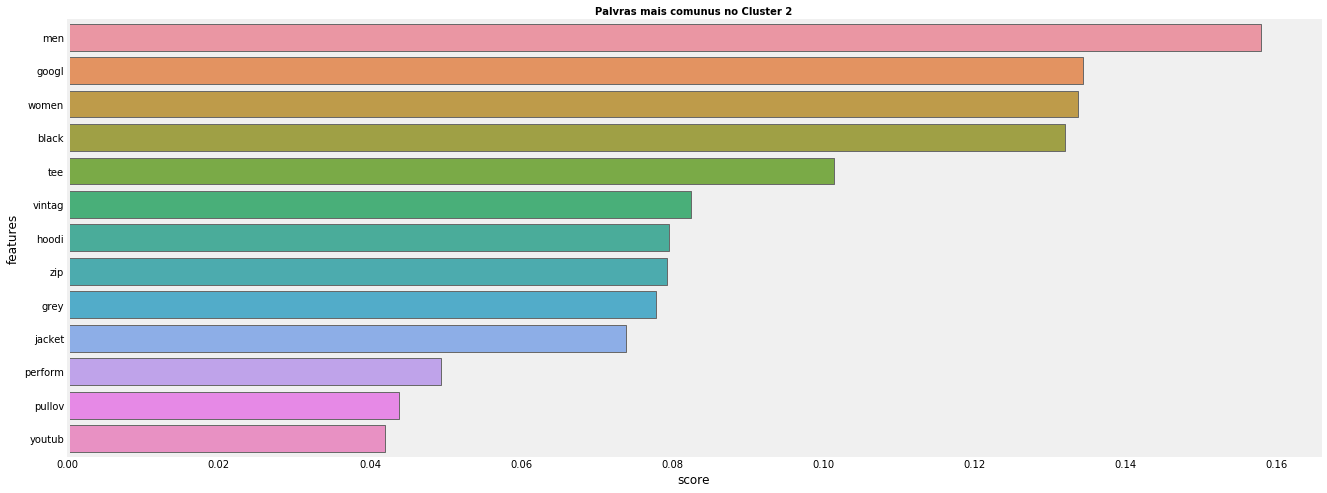

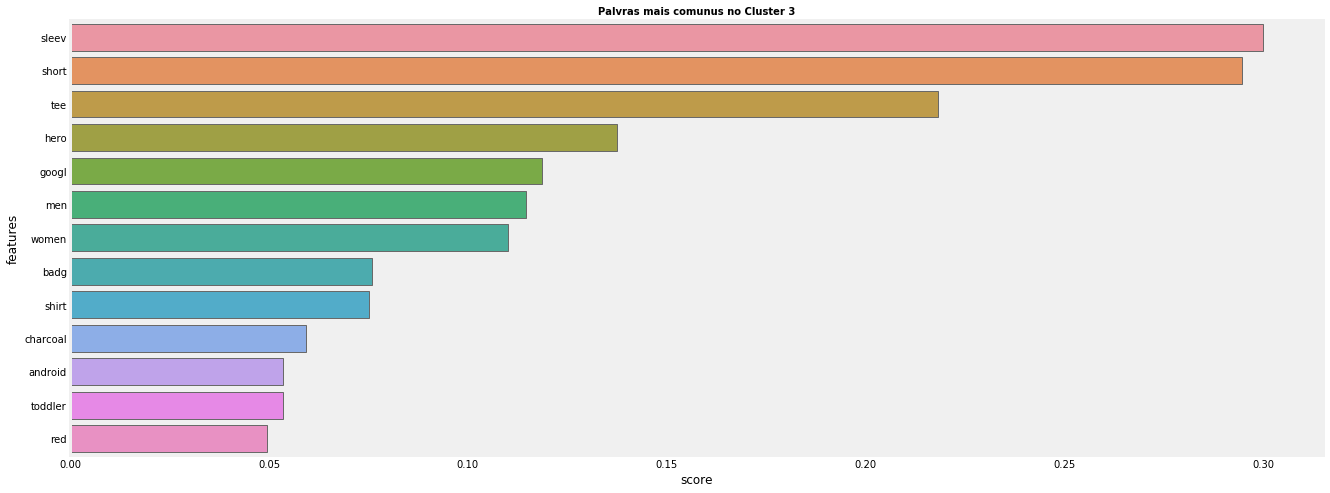

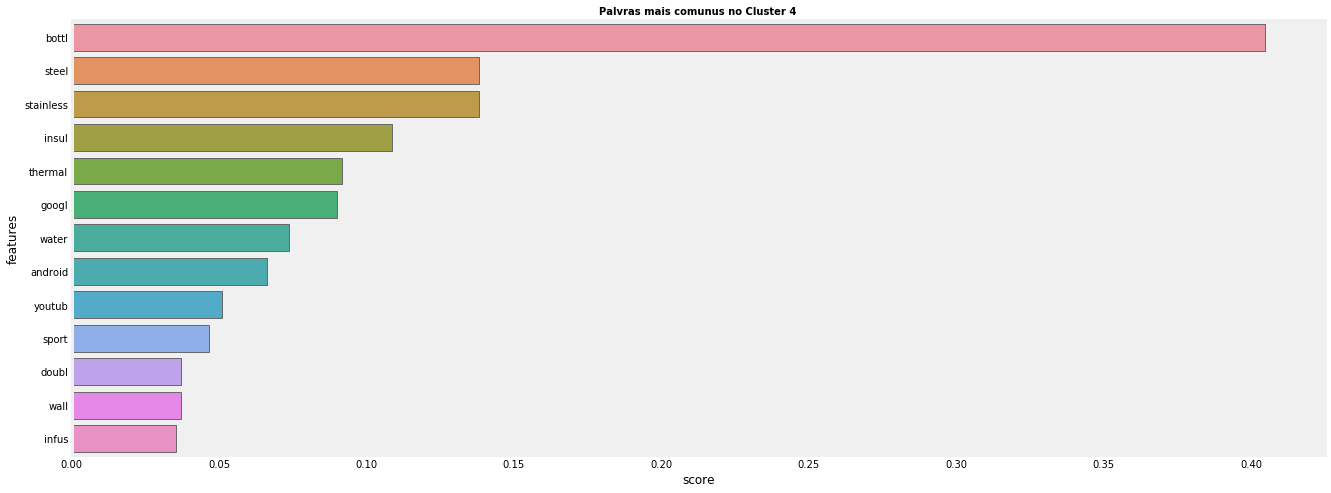

In [55]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

#### Map of Words
Agora que podemos olhar os gráficos acima e ver as melhores palavras pontuadas em cada cluster, também é interessante torná-lo mais bonito fazendo um mapa de palavras de cada cluster!

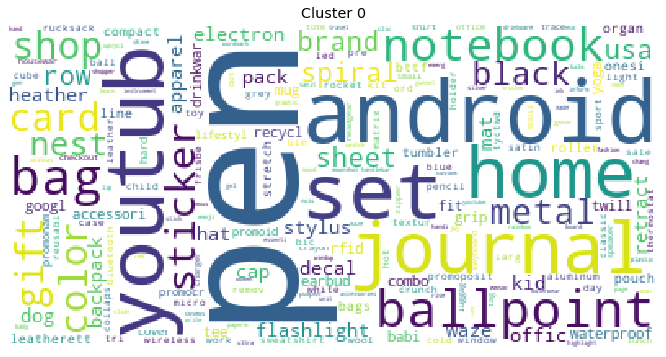

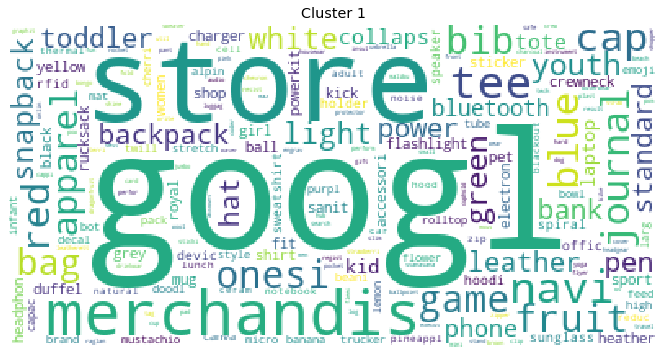

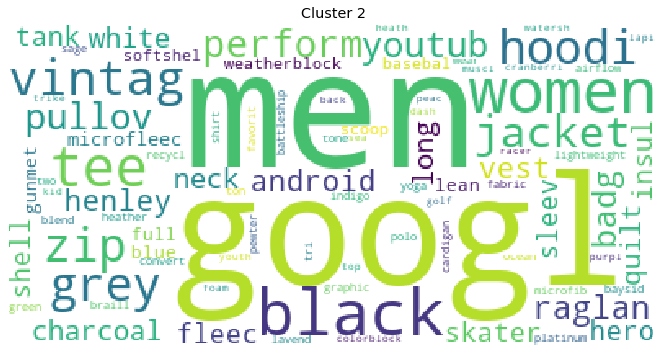

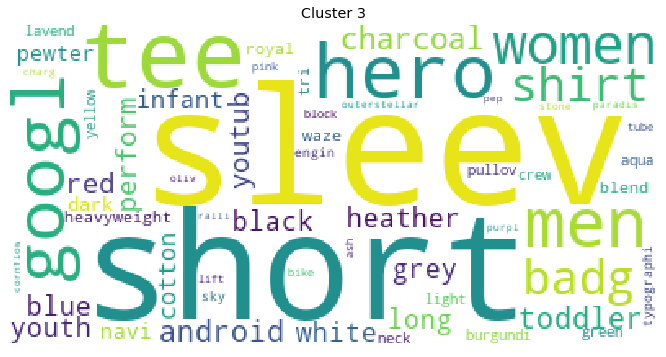

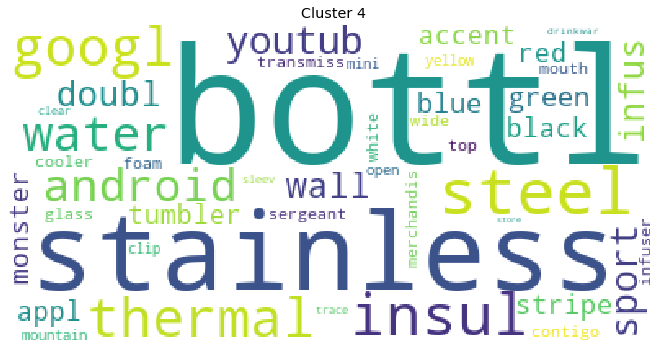

In [56]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

Nesse agrupamento, criamos $5$ grupos de texto onde pegamos todas as palavras que possam dizer alguma coisa sobre nosso dataset. 



## Agrupamento de Produtos

Vamos fazer o mesmo procedimento, mas agora usando os produtos que quer foram comprado em nosso dataset.

Para isso vamos usar os processamento de texto usado na seção anterior. Onde vamos extrair as palavras usando Stop Words e Stemming. Depois, vamos fazer uma analise de escolha do tamanho do nosso cluster e aṕos seguiremos o que foi feito na seção anterior.

Por ultimo nessa seção iremos fazer um PCA para analisar melhor nosso agrupamento. E com isso iremos conseguir categorizar os nosso Produtos para que possamos separar por Clientes.

In [57]:
products = pd.DataFrame(x[x['Transaction']==1]['v2ProductName'].unique()).rename(columns = {0:'Description'})
products.shape

(558, 1)

In [58]:
products_list = products['Description'].to_list()

In [59]:
corpus = processCorpus(products_list, 'english')


Nb of keywords in variable 'Description': 381


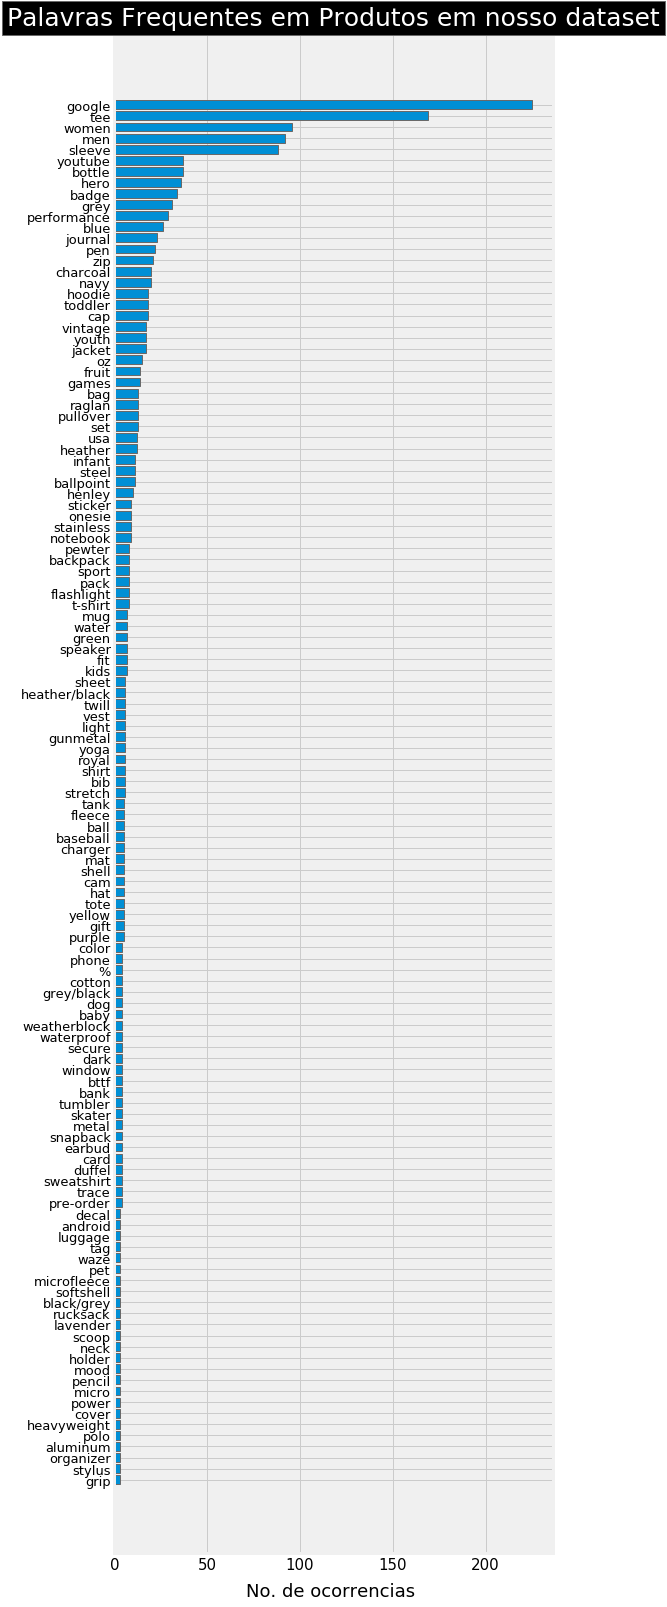

In [60]:
promo = pd.DataFrame(data['v2ProductName'].unique()).rename(columns = {0:'Description'})
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(promo)
list_promo = []
for k,v in count_keywords.items():
    list_promo.append([keywords_select[k],v])
list_promo.sort(key = lambda x:x[1], reverse = True)
liste = sorted(list_promo, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 28))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("No. de ocorrencias ", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Palavras Frequentes em Produtos em nosso dataset",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

**Estatística de Palavras**

In [61]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)


558 rows


,0,1,2,3,4,5,6,7,8,9,...,548,549,550,551,552,553,554,555,556,557
watersh,0.564048,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
full,0.486130,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
hoodi,0.372606,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.580951,0.0,0.0,0.0,0.0,0.0,0.0
zip,0.360139,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
grey,0.313663,0.0,0.0,0.0,0.0,0.0,0.442059,0.0,0.0,0.0,...,0.393598,0.0,0.0,0.489050,0.0,0.0,0.0,0.0,0.0,0.0


Escolhendo O Número de Clusters

In [62]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
#silhouette(kmeans_results, final_df, plot=True)

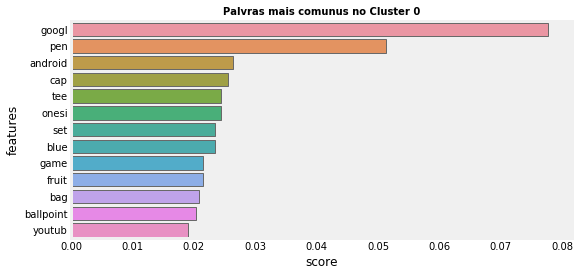

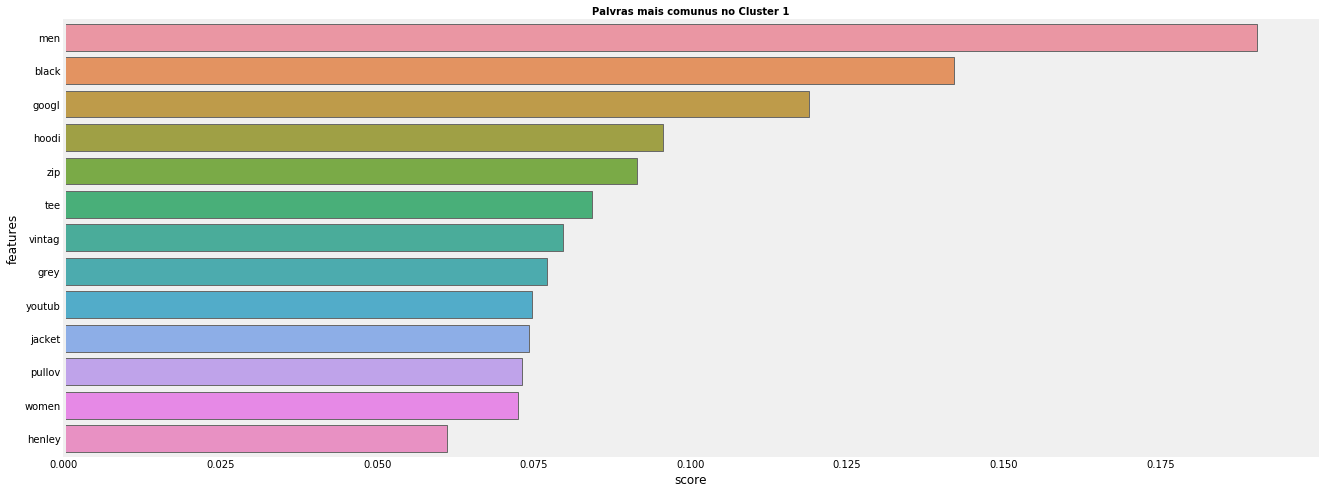

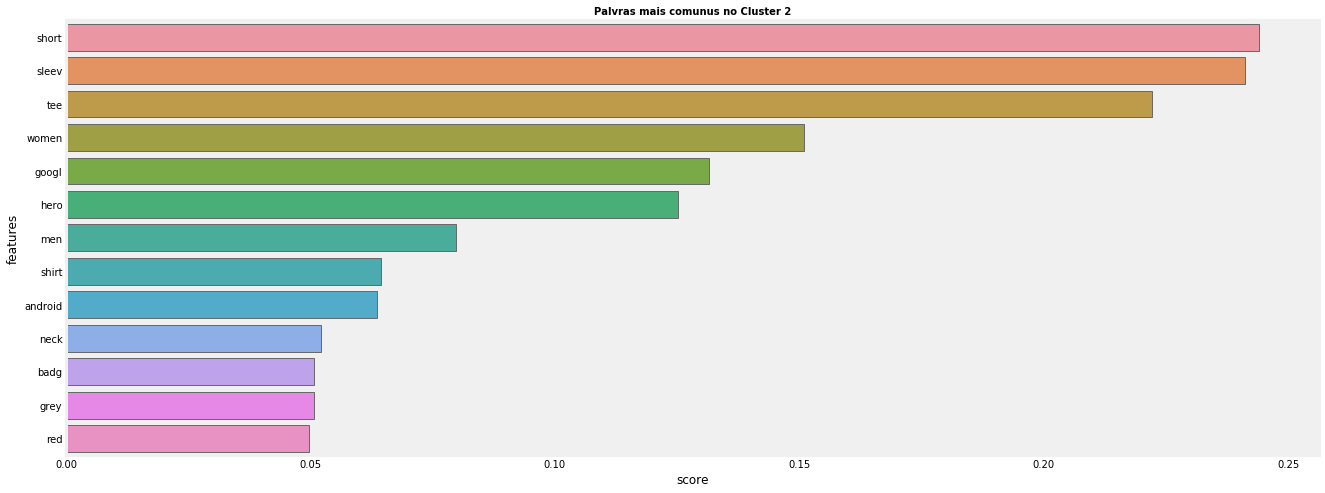

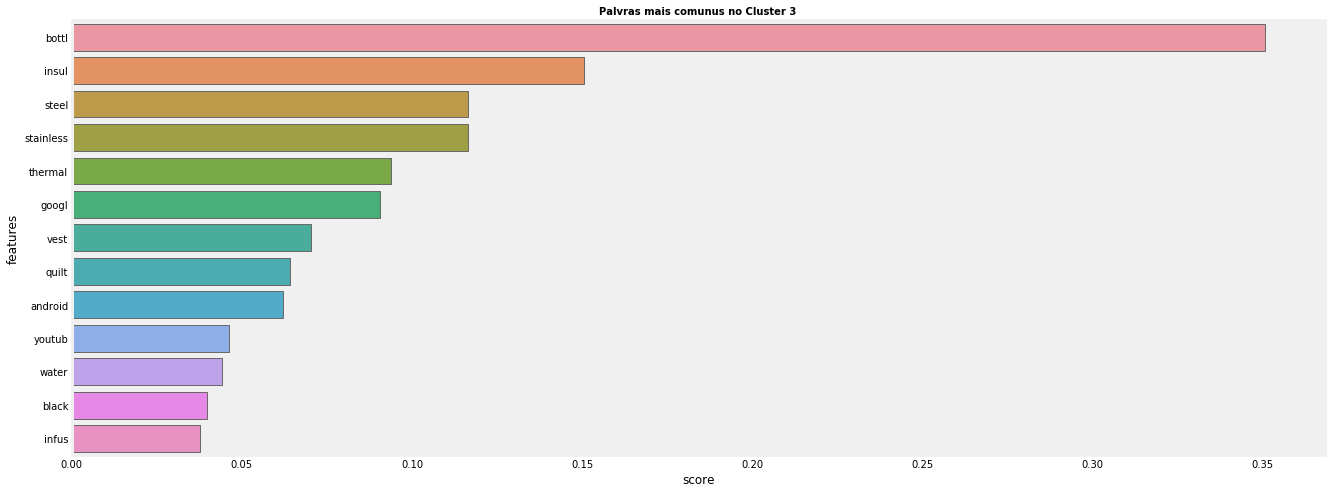

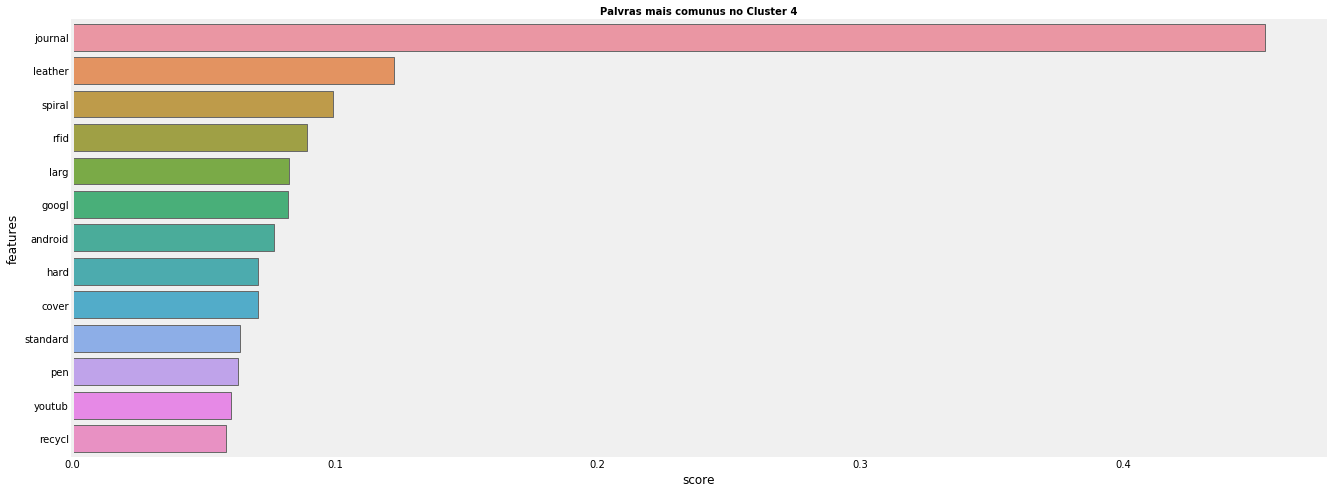

In [63]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

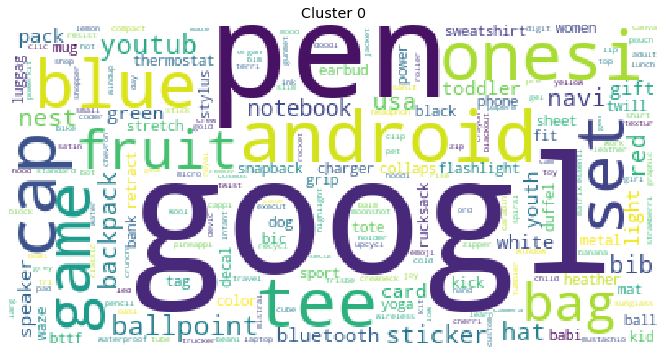

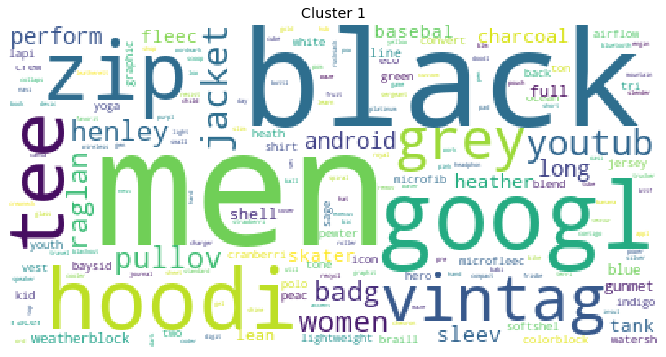

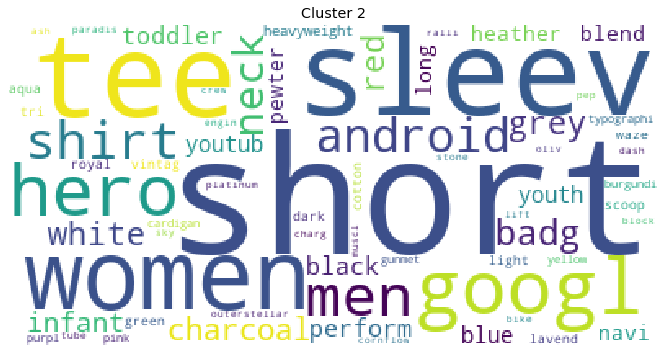

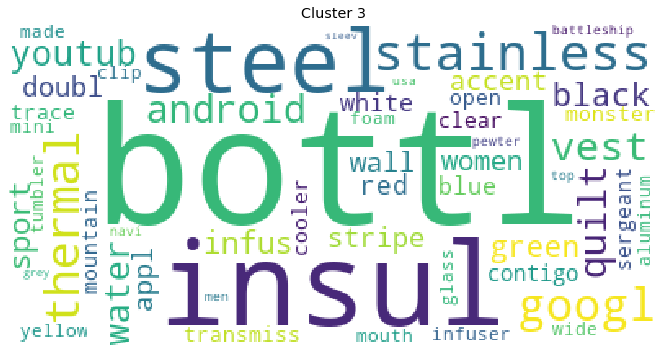

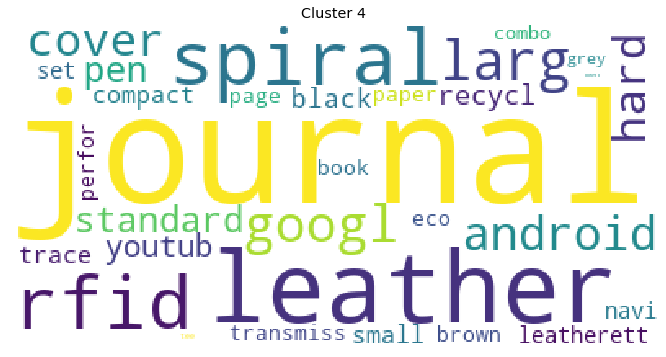

In [64]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [65]:
matrix = final_df.as_matrix()
for n_clusters in range(3,15):
    kmeans = cluster.KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.024819186965212015
For n_clusters = 4 The average silhouette_score is : 0.03241724801918
For n_clusters = 5 The average silhouette_score is : 0.033020861801671526
For n_clusters = 6 The average silhouette_score is : 0.039326529444042205
For n_clusters = 7 The average silhouette_score is : 0.041082741476004415
For n_clusters = 8 The average silhouette_score is : 0.03546513940171825
For n_clusters = 9 The average silhouette_score is : 0.055184728345177764
For n_clusters = 10 The average silhouette_score is : 0.04863994172109238
For n_clusters = 11 The average silhouette_score is : 0.05183290610017269
For n_clusters = 12 The average silhouette_score is : 0.053795313031791664
For n_clusters = 13 The average silhouette_score is : 0.0570230113972473
For n_clusters = 14 The average silhouette_score is : 0.06598241562228027


In [66]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.036:
    kmeans = cluster.KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.03783445121732115


In [67]:
pd.Series(clusters).value_counts()


0    255
1    118
2    101
3     43
4     41
dtype: int64

**Principal Component Analysis**

Para garantir que esses clusters sejam realmente distintos, examino sua composição. Dado o grande número de variáveis da matriz inicial, primeiro realizo um PCA:

In [68]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(final_df_array)
pca_samples = pca.transform(final_df_array)

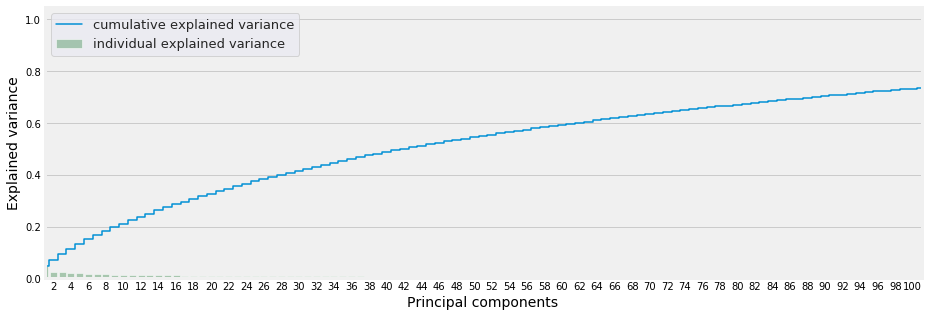

In [69]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(final_df_array.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,final_df_array.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

Vemos que o número de componentes necessários para explicar os dados é extremamente importante: precisamos de mais de 100 componentes para explicar 90% da variância dos dados. Na prática, decido manter apenas um número limitado de componentes, uma vez que essa decomposição é realizada apenas para visualizar os dados:

In [70]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(final_df_array)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)
mat.dropna(inplace = True)

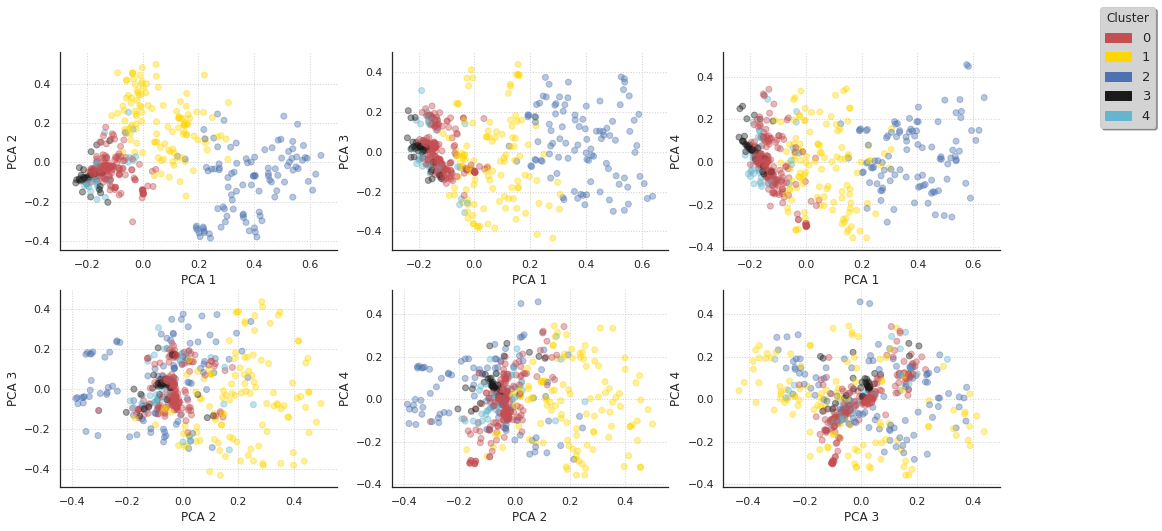

In [71]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()


### Agrupamento por Categoria de Produto

Na seção anterior, os diferentes produtos foram agrupados em cinco clusters. Para preparar o restante da análise, um primeiro passo consiste em introduzir essas informações no dataframe. Para fazer isso, crio a variável categórica **categ_product** onde indico o cluster de cada produto:

In [72]:
products_list = x['v2ProductName'].unique().tolist()
corresp = dict()
for key, val in zip (products_list, clusters):
    corresp[key] = val 
#__________________________________________________________________________
x['categ_product'] = x.loc[:, 'v2ProductName'].map(corresp)

Em uma segunda etapa, decido criar as variáveis **categ_N** (com $ N \in [0: 4] $) que contém o valor gasto em cada categoria de produto:

In [73]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = x[x['categ_product'] == i]
    price_temp = df_temp['productPrice'] * (df_temp['productQuantity'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    x.loc[:, col] = price_temp
    x[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
x[['categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']].sample(5)

,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
5295361,4.0,0.0,0.0,0.0,0.0,0.0
5195287,2.0,0.0,0.0,0.0,0.0,0.0
6357156,2.0,0.0,0.0,0.0,0.0,0.0
7901226,0.0,0.0,0.0,0.0,0.0,0.0
7298577,0.0,0.0,0.0,0.0,0.0,0.0


Até agora, as informações relacionadas a um único pedido eram divididas em várias linhas do dataframe (uma linha por produto). Eu decido coletar as informações relacionadas a um pedido específico e colocá-las em uma única entrada. Portanto, crio um novo dataframe que contém, para cada pedido, o valor da cesta, bem como a forma como ele é distribuído nas 5 categorias de produtos:

In [74]:
#___________________________________________
# soma de compras / usuário e pedido
temp = x.groupby(by=['fullVisitorId', 'item_transactionId'], as_index=False)['productPrice'].sum()
basket_price = temp.rename(columns = {'productPrice':'Basket Price'})
#____________________________________________________________
# porcentagem do preço do pedido / categoria do produto
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = x.groupby(by=['fullVisitorId', 'item_transactionId'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 
#_____________________
# data do pedido
x['date_int'] = x['date'].astype('int64')
temp = x.groupby(by=['fullVisitorId', 'item_transactionId'], as_index=False)['date_int'].mean()
x.drop('date_int', axis = 1, inplace = True)
basket_price.loc[:, 'date'] = pd.to_datetime(temp['date_int'])
#______________________________________
# seleção de entradas significativas:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('fullVisitorId', ascending = True)[:5]

,fullVisitorId,item_transactionId,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,date
0,1049505592515499633,ORD201612132505,575660000,0.000000e+00,0.0,0.0,0.0,79960000.0,2016-12-13 00:00:00.000000000
1,1075314772722686078,ORD20161112384,12561100000,6.599000e+08,0.0,0.0,0.0,0.0,2016-11-12 00:00:00.000000000
2,1116962533790637551,ORD201708222811,13502180000,8.443600e+08,805860000.0,162500000.0,239840000.0,0.0,2017-08-22 00:00:00.000000000
3,1116962533790637551,ORD201709162650,14746120000,1.161820e+09,0.0,39960000.0,89880000.0,161880000.0,2017-09-16 00:00:00.000003072
4,1118461469547433587,ORD20180130619,307840000,0.000000e+00,0.0,114340000.0,0.0,0.0,2018-01-30 00:00:00.000000000


O dataframe basket_price contém informações por um período de 2 anos. Para isso eu vou separa em alguns periodos para treinar e outro para testa

In [75]:
print(basket_price['date'].min(), '->',  basket_price['date'].max())

2016-08-05 00:00:00 -> 2018-04-16 00:00:00


In [76]:
set_entrainement = basket_price[basket_price['date'] < datetime.date(2017,10,16)]
set_test         = basket_price[basket_price['date'] >= datetime.date(2017,10,16)]
basket_price = set_entrainement.copy(deep = True)

In [77]:
(set_test.shape,set_entrainement.shape)

((40, 9), (209, 9))

Em uma segunda etapa, agrupo as diferentes entradas que correspondem ao mesmo usuário. Assim, determino a quantidade de compras realizadas pelo usuário, bem como os valores mínimo, máximo, média e o valor total gasto em todas as visitas:

In [78]:
#________________________________________________________________
# número de visitas e estatísticas sobre a quantidade de carrinho / usuários
transactions_per_user=basket_price.groupby(by=['fullVisitorId'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['fullVisitorId'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['fullVisitorId'])['categ_0'].sum()
transactions_per_user.sort_values('fullVisitorId', ascending = True)

,fullVisitorId,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,1049505592515499633,1,575660000,575660000,5.756600e+08,575660000,0.000000,0.000000,0.000000,0.000000,13.890143
1,1075314772722686078,1,12561100000,12561100000,1.256110e+10,12561100000,5.253521,0.000000,0.000000,0.000000,0.000000
2,1116962533790637551,2,13502180000,14746120000,1.412415e+10,28248300000,7.101949,2.852773,0.716716,1.167221,0.573061
3,1150575182630321443,1,249240000,249240000,2.492400e+08,249240000,0.000000,0.000000,0.000000,0.000000,14.427861
4,1224021848731205993,1,10570440000,10570440000,1.057044e+10,10570440000,0.000000,1.694915,0.605084,0.000000,0.000000
5,1235024616645642362,1,7786780000,7786780000,7.786780e+09,7786780000,0.872761,0.000000,0.872761,0.000000,0.000000
6,124850203340830679,1,11908900000,11908900000,1.190890e+10,11908900000,174.063767,176.000806,22.925039,229.754217,215.347681
7,1337744272385974839,1,2499500000,2499500000,2.499500e+09,2499500000,0.000000,6.271654,3.580716,0.000000,0.000000
8,1408568077869595615,1,3152620000,3152620000,3.152620e+09,3152620000,4.565726,8.523704,0.000000,0.000000,0.000000
9,1447936115749284814,1,4601220000,4601220000,4.601220e+09,4601220000,5.839321,1.459613,0.000000,0.000000,0.000000


Por fim, defino duas variáveis adicionais que fornecem o número de dias decorridos desde a primeira compra (**Primeira Compra) e o número de dias desde a última compra (Última Compra**):

In [79]:
last_date = basket_price['date'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['fullVisitorId'])['date'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['fullVisitorId'])['date'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['date']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['date']

transactions_per_user[:5]

,fullVisitorId,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,1049505592515499633,1,575660000,575660000,5.756600e+08,575660000,0.000000,0.000000,0.000000,0.000000,13.890143,306,306
1,1075314772722686078,1,12561100000,12561100000,1.256110e+10,12561100000,5.253521,0.000000,0.000000,0.000000,0.000000,337,337
2,1116962533790637551,2,13502180000,14746120000,1.412415e+10,28248300000,7.101949,2.852773,0.716716,1.167221,0.573061,29,54
3,1150575182630321443,1,249240000,249240000,2.492400e+08,249240000,0.000000,0.000000,0.000000,0.000000,14.427861,188,188
4,1224021848731205993,1,10570440000,10570440000,1.057044e+10,10570440000,0.000000,1.694915,0.605084,0.000000,0.000000,121,121


Uma categoria de cliente de interesse particular é a de clientes que fazem apenas uma compra. Um dos objetivos pode ser, por exemplo, direcionar esses clientes para retê-los.

In [80]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("No. clientes com uma única compra: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))


No. clientes com uma única compra: 178/192   (92.71%)


**Criação de categorias de clientes**

O dataframe transactions_per_user contém um resumo de todos os comandos que foram feitos. Cada entrada neste dataframe corresponde a um cliente específico. Eu uso essas informações para caracterizar os diferentes tipos de clientes e mantenho apenas um subconjunto de variáveis:

In [81]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].as_matrix()

Na prática, as diferentes variáveis que selecionei têm intervalos de variação bastante diferentes e, antes de continuar a análise, crio uma matriz onde esses dados são padronizados

In [82]:
scaler = StandardScaler()
scaler.fit(matrix)
print('valores médios: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

valores médios: 
------------------------------------------------------------------------------------------
 [1.08854167e+00 6.31674346e+09 6.95227854e+09 6.61518103e+09
 4.67412115e+01 9.55109708e+00 7.34272762e+00 5.40919365e+01
 7.50574141e+01]


A seguir, criarei grupos de clientes. Na prática, antes de criar esses clusters, é interessante definir uma base de menor dimensão que permita descrever a matriz scaled_matrix. Neste caso, utilizarei esta base para criar uma representação dos diferentes clusters e assim verificar a qualidade da separação dos diferentes grupos. Portanto, eu realizo um PCA de antemão:

In [83]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

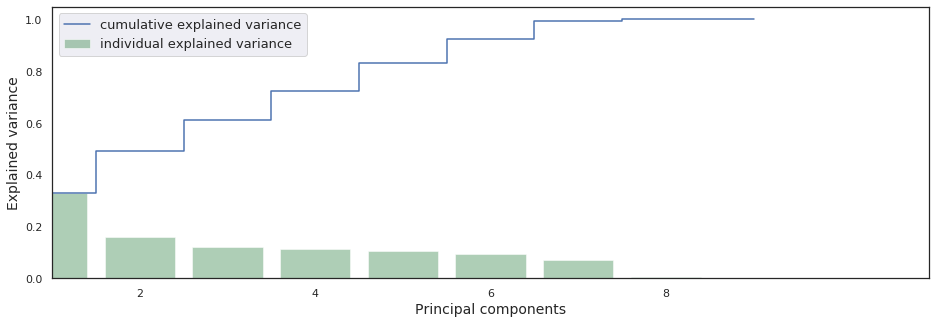

In [84]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

Neste ponto, eu defino clusters de clientes da matriz padronizada que foi definida anteriormente vamos usar o mesmo método anterior. Eu escolho o número de clusters com base na pontuação da silhueta e acho que a melhor pontuação é obtida com 5 clusters:

In [85]:
n_clusters = 5
kmeans = cluster.KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.720


In [86]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['No. de clientes']).T


,0,2,4,3,1
No. de clientes,177,11,2,1,1


In [87]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

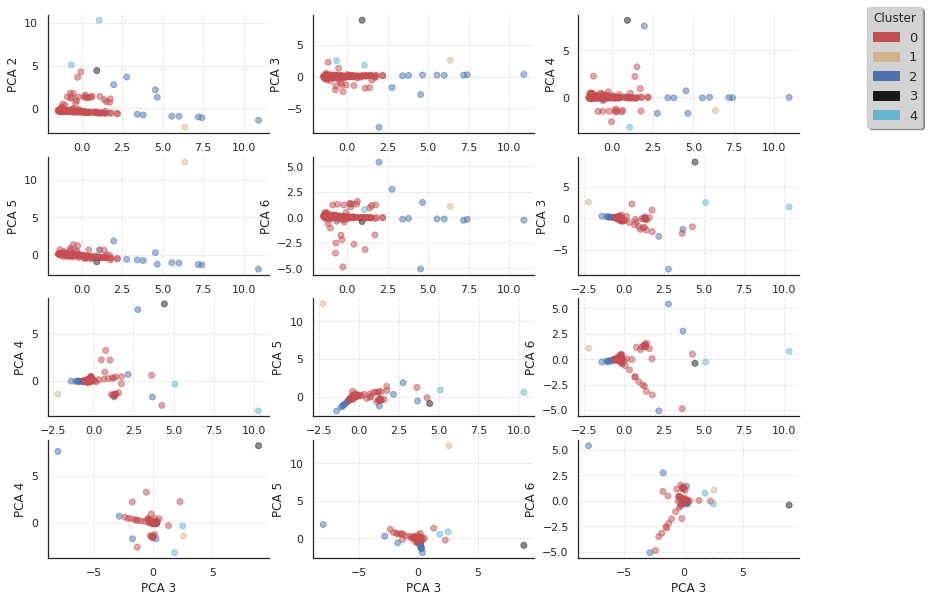

In [88]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()


In [89]:
# Plot The Graph

#sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
#sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
#graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

**Tipo de clientes**

Nesta fase, verifiquei que os diferentes clusters são de fato disjuntos (pelo menos, de uma forma global). Resta entender os hábitos dos clientes em cada cluster. Para fazer isso, começo adicionando ao dataframe `selected_customers` uma variável que define o cluster ao qual cada cliente pertence:

In [90]:
selected_customers.loc[:, 'cluster'] = clusters_clients


Em seguida, calculo a média do conteúdo desse dataframe selecionando primeiro os diferentes grupos de clientes. Dá acesso, por exemplo, ao preço médio dos cabazes, ao número de visitas ou aos montantes totais gastos pelos clientes dos diferentes clusters. Eu também determino o número de clientes em cada grupo (variável ** tamanho **):

In [91]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('fullVisitorId', axis = 1, inplace = True)
print('número de clientes:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

número de clientes: 192


Finalmente, eu reorganizo o conteúdo do dataframe ordenando os diferentes clusters: primeiro, em relação ao valor gasto em cada categoria de produto e, em seguida, de acordo com o valor total gasto:

In [92]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 35].index.values[0])
#___________________________________
liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,0.0,1.067797,4.856636e+09,5.154334e+09,5.007831e+09,5.445821e+09,39.376975,5.849299,4.275489,16.381567,16.413472,177
1,2.0,1.272727,2.844883e+10,3.300819e+10,3.060627e+10,3.607769e+10,143.798083,72.589522,1.245252,12.194796,5.309195,11
2,3.0,1.000000,9.917760e+09,9.917760e+09,9.917760e+09,9.917760e+09,22.636160,0.000000,639.344368,1023.431097,0.000000,1
3,3.0,1.000000,9.917760e+09,9.917760e+09,9.917760e+09,9.917760e+09,22.636160,0.000000,639.344368,1023.431097,0.000000,1
4,1.0,1.000000,2.679908e+10,2.679908e+10,2.679908e+10,2.679908e+10,0.000000,0.000000,0.000000,0.000000,11447.437748,1
5,4.0,2.000000,1.768092e+09,1.135675e+10,5.171411e+09,1.208629e+10,200.086520,0.000000,0.000000,3164.270297,0.000000,2


Criei uma representação dos diferentes morfotipos. Para fazer isso, defino uma classe para criar "Gráficos de radar"

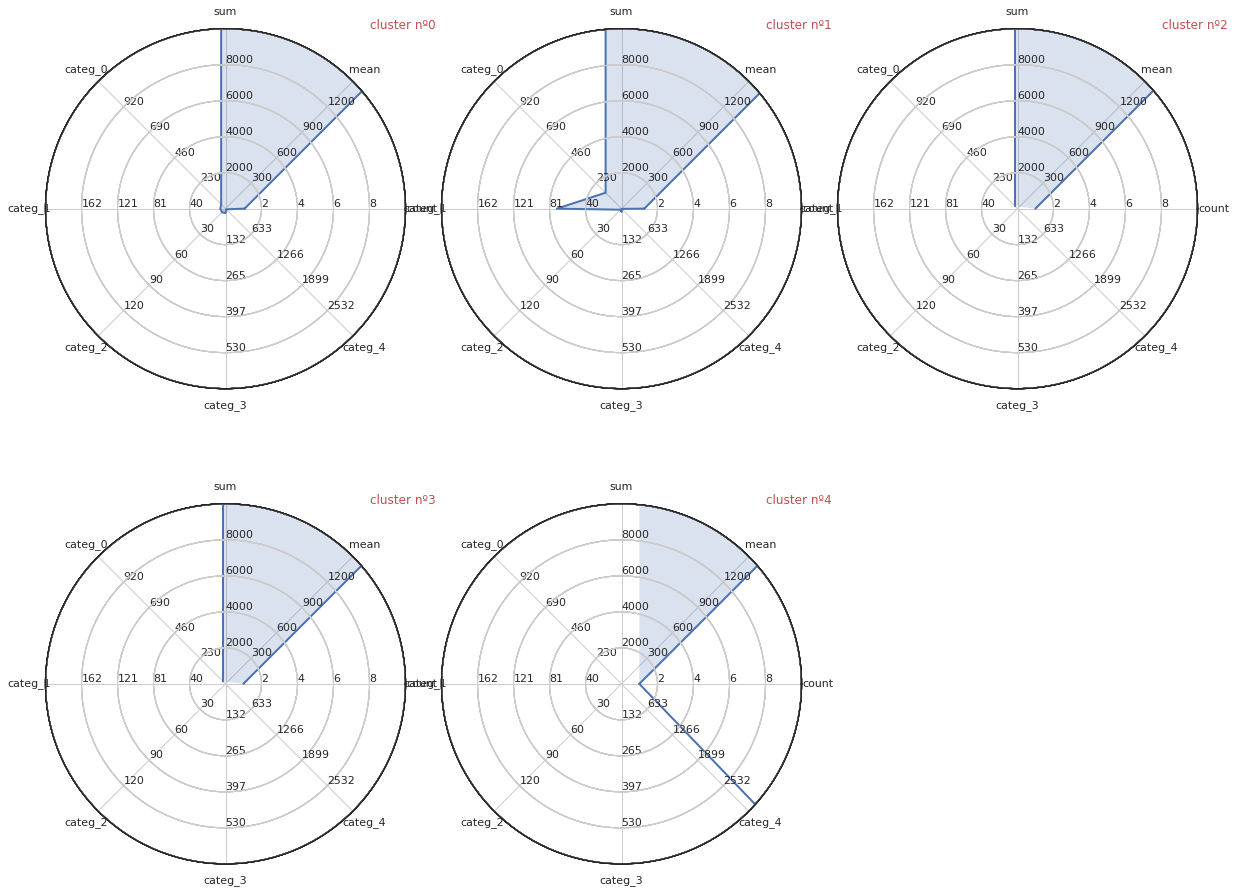

In [155]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
#ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 1150], [0.01, 202], [0.01, 150], [0.01, 662], [0.01, 3165]]
index  = [0, 1, 2, 3,4]
n_clusters = 5
n_groups = n_clusters ; i_cols = 2
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

## Classificação de cliente 

Nesta parte, o objetivo será ajustar um classificador que irá classificar os consumidores nas diferentes categorias de clientes que foram estabelecidas na seção anterior. O objetivo é possibilitar essa classificação na primeira visita. Para cumprir esse objetivo, testarei vários classificadores implementados no scikit-learn. Em primeiro lugar, para simplificar seu uso, defino uma classe que permite fazer a interface com várias das funcionalidades comuns a esses diferentes classificadores:

In [94]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

Visto que o objetivo é definir a classe a que pertence um cliente e isso, logo na sua primeira visita, guardo apenas as variáveis que descrevem o conteúdo do cesto, e não levo em consideração as variáveis relacionadas com a frequência das visitas ou variações do preço da cesta ao longo do tempo:

In [95]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

Separando o dataset em treino e teste

In [96]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

### Support Vector Machine Classifier (SVC)
O primeiro classificador que uso é o classificador SVC. Para usá-lo, crio uma instância da classe Class_Fit e, em seguida, callgrid_search (). Ao chamar este método, forneço como parâmetros:

* os hiperparâmetros para os quais procurarei um valor ideal
* o número de dobras a ser usado para validação cruzada

In [97]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [98]:
svc.grid_fit(X = X_train, Y = Y_train)


In [99]:
svc.grid_predict(X_test, Y_test)


Precision: 1.72 % 


#### Curva de aprendizado

Uma maneira típica de testar a qualidade de um ajuste é desenhar uma curva de aprendizado. Em particular, este tipo de curvas permite detectar possíveis inconvenientes no modelo, associados, por exemplo, ao sobreajuste ou insuficiente. Isso também mostra até que ponto o modo pode se beneficiar de uma amostra de dados maior. Para desenhar essa curva, uso o <a href=" http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr- self-examples-model-selection -pad-learning-curve-py" >código de documentação do scikit-learn novamente</a>

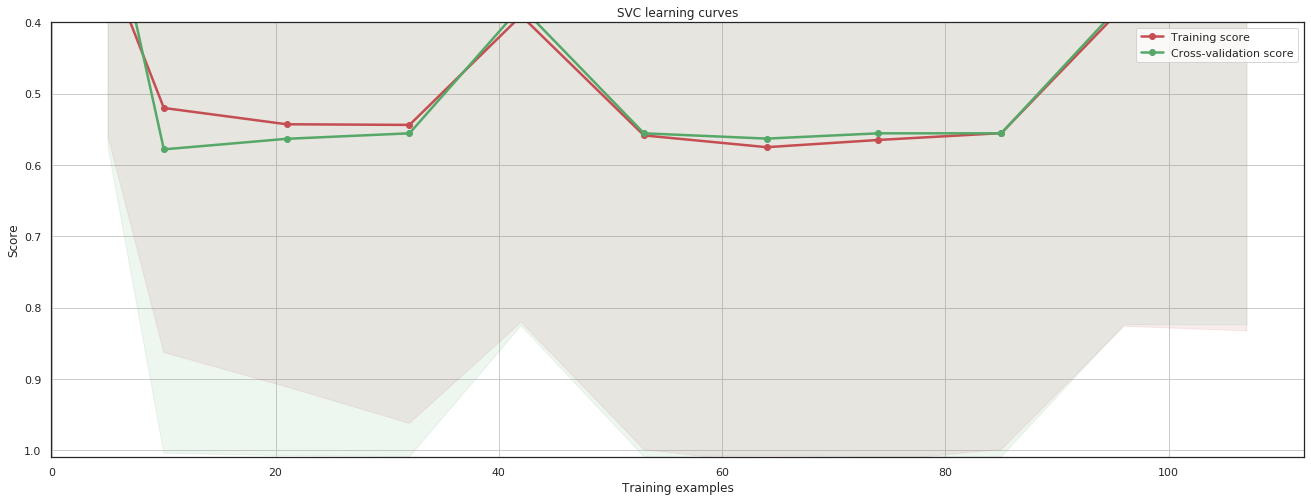

In [100]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.4],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

### Logistic Regression
Agora considero o classificador de regressão logística. Como antes, crio uma instância da classe Class_Fit, ajusto o modelo nos dados de treinamento e vejo como as previsões se comparam aos valores reais:

In [101]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 89.66 % 


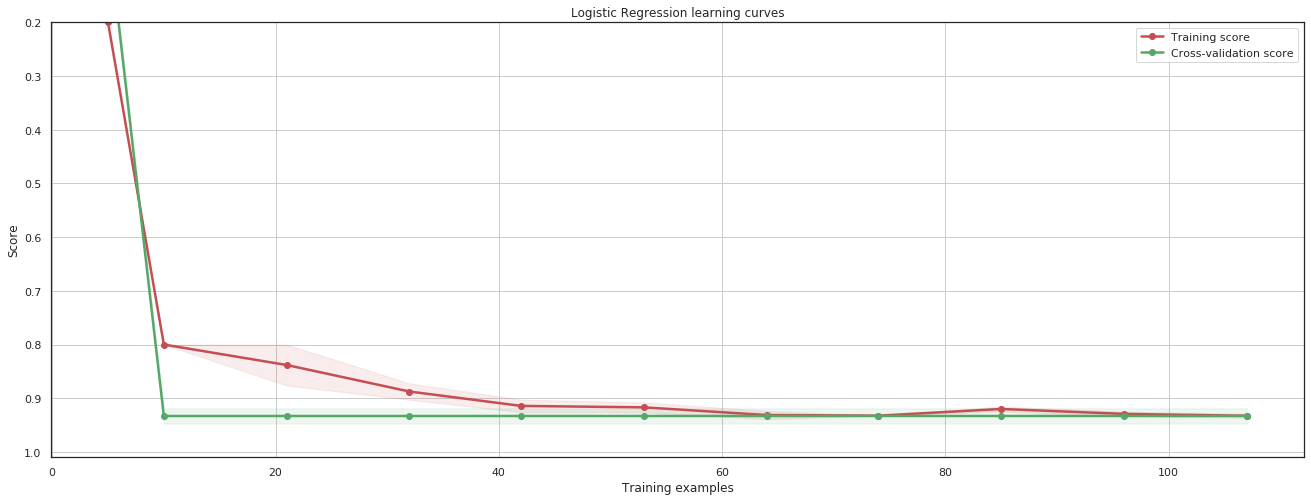

In [102]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.2], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

###  k-Nearest Neighbors

In [103]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,15,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 98.28 % 


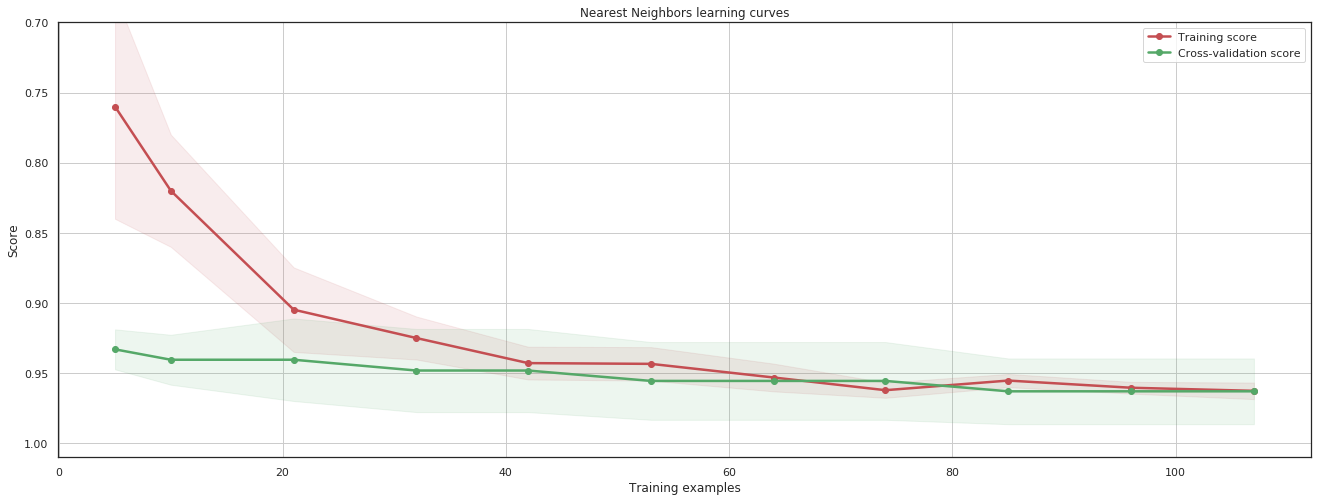

In [104]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


### Decision Tree

In [105]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 100.00 % 


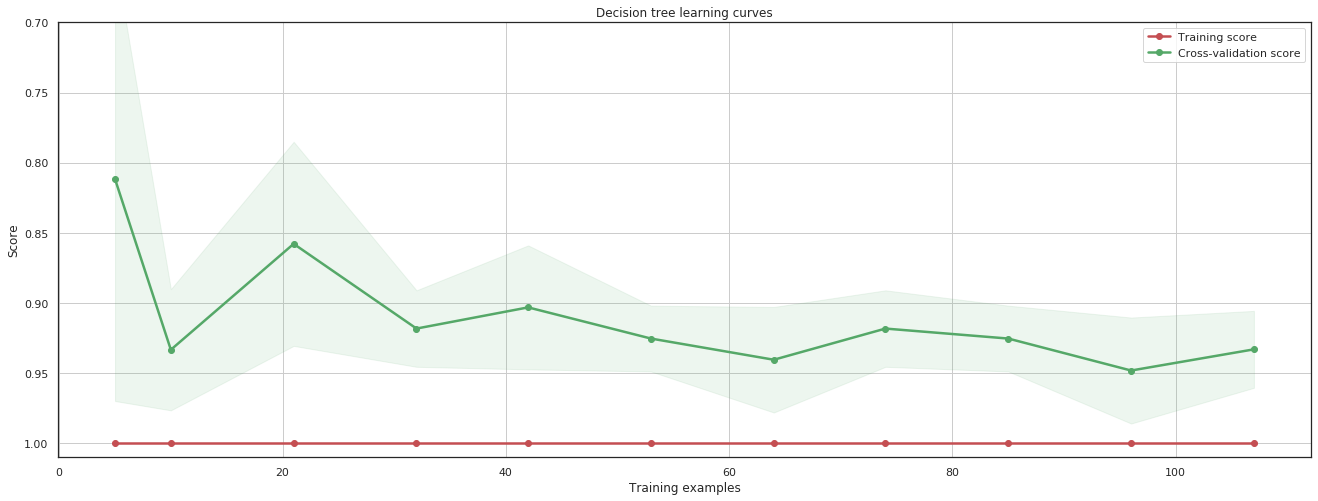

In [106]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Random Forest

In [107]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 100.00 % 


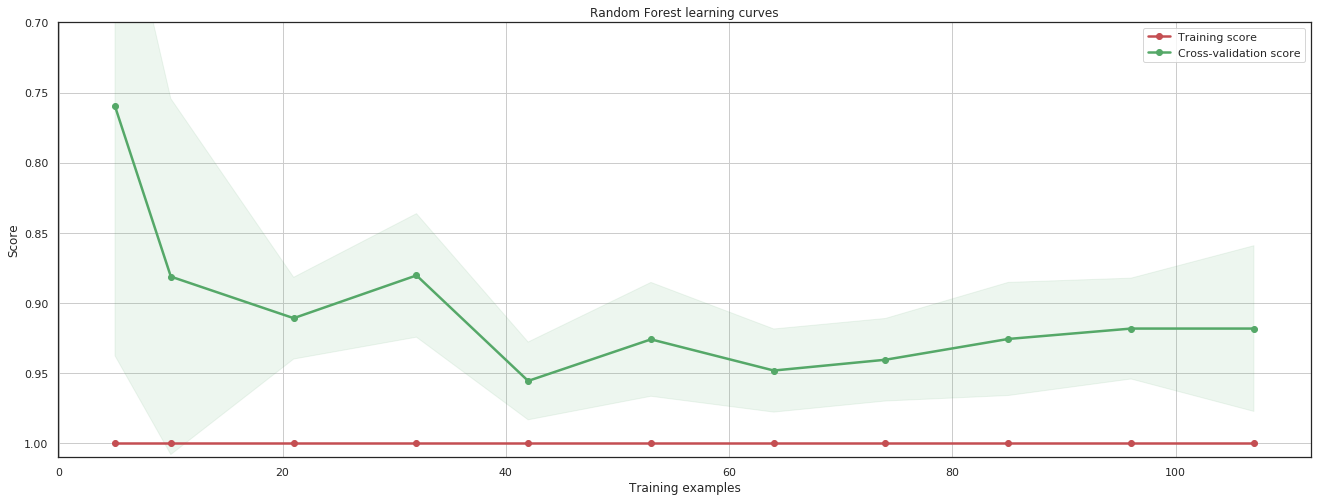

In [108]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### AdaBost Classifier

In [109]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 100.00 % 


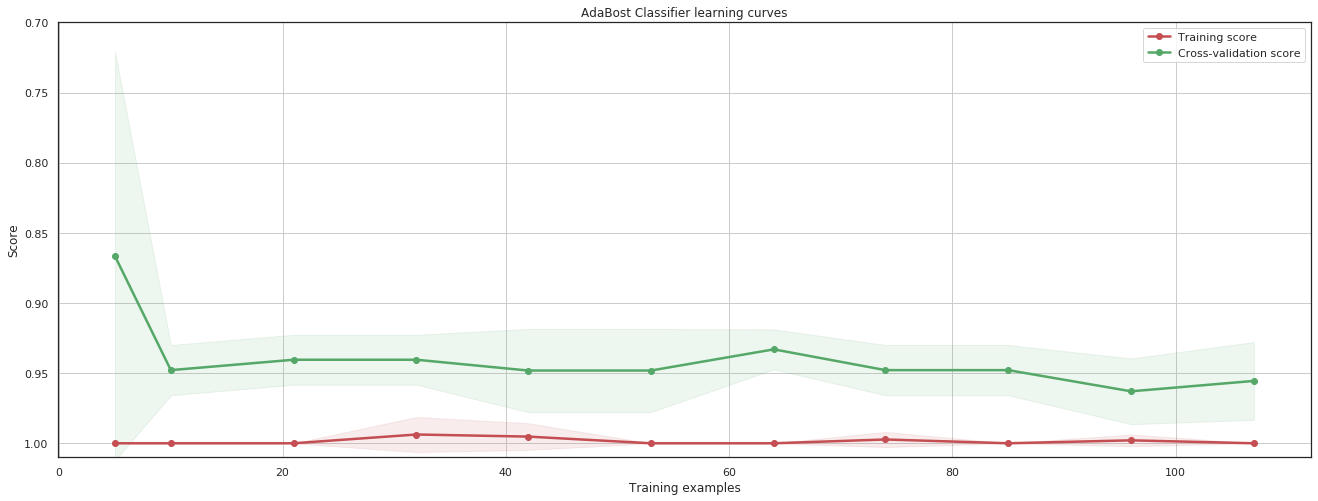

In [110]:
g = plot_learning_curve(rf.grid.best_estimator_, "AdaBost Classifier learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


### Gradient Boost Classifier

In [111]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 96.55 % 


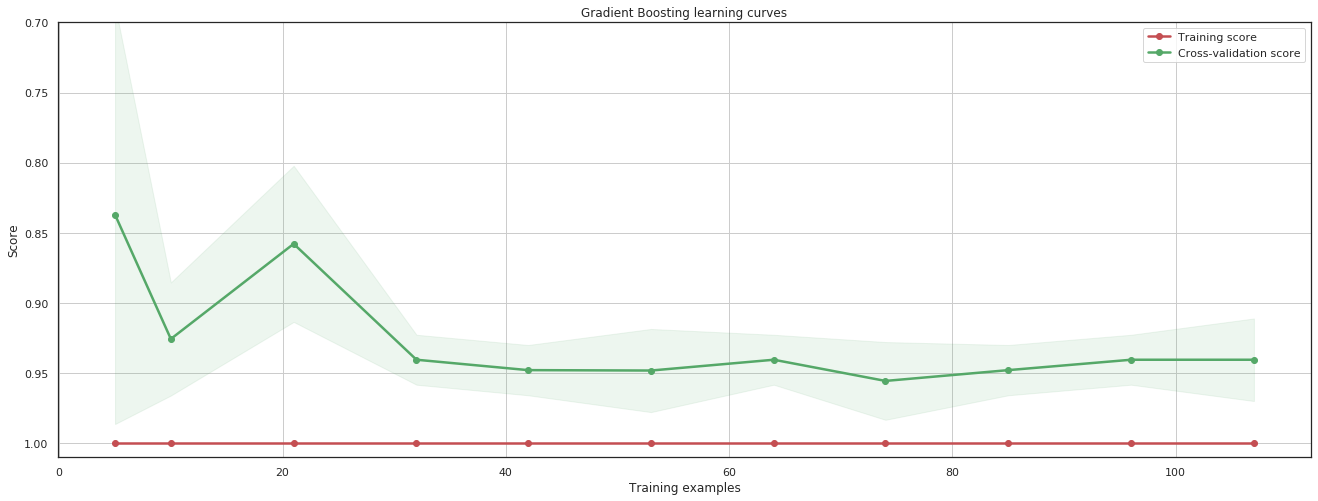

In [112]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Voting Classifier

In [113]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [114]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')    

In [115]:
votingC = votingC.fit(X_train, Y_train)


In [116]:

predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 98.28 % 


### Stacking Classifier

In [117]:
from sklearn.ensemble import StackingClassifier

In [118]:
stacking = StackingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)],
                              final_estimator =tr_best , cv = 5,n_jobs = -1)

In [119]:
stacking = stacking.fit(X_train, Y_train)


In [120]:
predictions = stacking.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 96.55 % 


## 6. Testando previsões

Na seção anterior, alguns classificadores foram treinados para categorizar os clientes. Até então, toda a análise era baseada nos dados dos primeiros 10 meses. Nesta seção, eu testo o modelo nos últimos dois meses do conjunto de dados, que foi armazenado no dataframe `set_test`:

In [121]:
basket_price = set_test.copy(deep = True)


Em uma primeira etapa, reagrupo e reformata esses dados de acordo com o mesmo procedimento usado no conjunto de treinamento. No entanto, estou corrigindo os dados para levar em consideração a diferença de tempo entre os dois conjuntos de dados e ponderar as variáveis ** contagem ** e ** soma ** para obter uma equivalência com o conjunto de treinamento:

In [122]:
transactions_per_user=basket_price.groupby(by=['fullVisitorId'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['fullVisitorId'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['fullVisitorId'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('fullVisitorId', ascending = True)[:5]

,fullVisitorId,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,1118461469547433587,5,307840000,307840000,307840000,1539200000,0.000000,0.000000,37.142672,0.000000,0.000000
1,147321363109389105,5,3871020000,3871020000,3871020000,19355100000,18.844646,0.000000,10.987285,0.000000,0.000000
2,174370066755715970,5,6437940000,6437940000,6437940000,32189700000,0.000000,0.000000,7.454558,0.000000,0.000000
3,1877970748354425630,5,1699140000,1699140000,1699140000,8495700000,0.000000,18.118578,5.647563,1.177066,4.587026
4,1879772545097205146,5,1143560000,1143560000,1143560000,5717800000,12.587009,0.000000,0.000000,0.000000,0.000000


Em seguida, converto o dataframe em uma matriz e retenho apenas as variáveis que definem a categoria à qual os consumidores pertencem. Neste nível, lembro-me do método de normalização que foi usado no conjunto de treinamento:

In [123]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].as_matrix()
scaled_test_matrix = scaler.transform(matrix_test)

Cada linha nesta matriz contém os hábitos de compra do consumidor. Nesta fase, trata-se de utilizar esses hábitos para definir a categoria a que pertence o consumidor. Essas categorias foram estabelecidas na Seção 4. ** Nesta etapa, é importante ter em mente que esta etapa não corresponde à própria etapa de classificação **. Aqui, preparamos os dados de teste definindo a categoria à qual pertencem os clientes. No entanto, esta definição usa dados obtidos ao longo de um período de 2 meses (por meio das variáveis ​​** contagem **, ** min **, ** max ** e ** soma **). O classificador definido na Seção 5 usa um conjunto mais restrito de variáveis ​​que serão definidas a partir da primeira compra de um cliente.

Aqui, trata-se de utilizar os dados disponíveis ao longo de um período de dois meses e utilizar esses dados para definir a categoria a que pertencem os clientes. Então, o classificador pode ser testado comparando suas previsões com essas categorias. Para definir a categoria a que pertencem os clientes, lembro-me da instância do método `kmeans` usado na seção 4. O método` predict` desta instância calcula a distância dos consumidores dos centróides das 11 classes de clientes e a menor distância definirá o pertencimento às diferentes categorias:

In [124]:
Y = kmeans.predict(scaled_test_matrix)


In [125]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

In [126]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 2.56 % 
______________________________ 
Logostic Regression
Precision: 92.31 % 
______________________________ 
k-Nearest Neighbors
Precision: 92.31 % 
______________________________ 
Decision Tree
Precision: 94.87 % 
______________________________ 
Random Forest
Precision: 92.31 % 
______________________________ 
Gradient Boosting
Precision: 97.44 % 


In [127]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 92.31 % 


In [128]:
predictions = stacking.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 89.74 % 


## Conlcusão
___

No trabalho feito nesse notebook é baseado num conjunto de dados fornecido pelo Google Analitycs, onde há interação de usuário em uma sessão. A partir desse conjunto separamos um os usuários que compraram um determinado produto. Nesse conjunto de dados retiramos informações das datas onde houve transação. No total, aproximadamente $\sim 250$clientes aparecem no banco de dados. 

Assim, fizemos a descrição dos diferentes produtos disponibilizados pelo conjunto de dados, que foi objeto de uma primeira classificação. Lá, agrupei os diferentes produtos em 5 categorias principais de mercadorias. Em uma segunda etapa, realizei uma classificação dos clientes analisando seus hábitos de consumo ao longo de um período de 2 anos. Classifiquei os clientes em 5 categorias principais com base no tipo de produtos que costumam comprar, no número de visitas que fazem e no valor que gastaram durante os 2 anos. Uma vez estabelecidas essas categorias, finalmente treinei vários classificadores cujo objetivo é poder classificar os consumidores em uma dessas 5 categorias e esta desde a primeira compra. Para isso, o classificador é baseado em 5 variáveis que são:

* média **: valor da transação da compra atual
* categ_N ** com $ N \ in [0: 4] $: porcentagem gasta na categoria de produto com índice $ N $

por ultimo, a qualidade das previsões dos diferentes classificadores foi testada nos últimos dois anos do conjunto de dados. Os dados foram então processados em duas etapas: primeiro, todos os dados foram considerados  para definir a categoria a que cada cliente pertence e, em seguida, as previsões do classificador foram comparadas com esta atribuição de categoria. Então descobri que $\sim 92\%$ dos clientes recebem as classificações certas.

Poderíamos ter feito um agrupamento por comportamento ao invés de produto, que nos diara bastante sobre o hábitos do clientes que fizeram alguma transação. Pode ser implementado depois.

## Bônus

Vamos implementar agora um modelo não muito sofistcado de propensão de comprar, dados informações dos clientes.

Para isso vamos escolher algumas features para nosso modelo.

In [129]:
hits = pd.read_csv('analytics/hits.csv',low_memory= True) # Se False, temos problema de memória
session = pd.read_csv('analytics/sessions.csv',low_memory= True)
products = pd.read_csv('analytics/products.csv',low_memory= True)

# compile the list of dataframes you want to merge
data_frames = [hits, session, products]
data = reduce(lambda  left,right: pd.merge(left,right,on=['visitId','fullVisitorId'],
                                            how='inner'), data_frames)

In [130]:
data["Transaction"] = 0 
for i in tqdm(range(len(visitor_trans))):

    if len(data[data['fullVisitorId']==visitor_trans[i]]['visitId'].unique()) >= 2:
        visitId = data[data['fullVisitorId']==visitor_trans[i]]['visitId'].unique()
        for j in visitId:
            if len(data[(data['fullVisitorId']==visitor_trans[i])&(data['visitId']==j)]['transaction_transactionId'].dropna().unique())> 0:
                data.loc[(data['fullVisitorId']==visitor_trans[i])&(data['visitId']==j),'Transaction'] = 1
            else:
                data.loc[(data['fullVisitorId']==visitor_trans[i])&(data['visitId']==j),'Transaction'] = 0
    else :
        data.loc[data['fullVisitorId']==visitor_trans[i],'Transaction']= 1                             
                         


100%|██████████| 230/230 [04:38<00:00,  1.21s/it]


In [131]:
df_trans = data[['fullVisitorId','visitId','time','eCommerceAction_action_type','promotionActionInfo_promoIsClick',
                 'promotionActionInfo_promoIsView','eCommerceAction_step','social_hasSocialSourceReferral',
                 'device_isMobile','totals_pageviews','totals_transactions',
                 'productPrice','productQuantity','Transaction']].copy()

In [132]:
df_trans.isnull().sum()

fullVisitorId                             0
visitId                                   0
time                                      0
eCommerceAction_action_type               0
promotionActionInfo_promoIsClick    8117816
promotionActionInfo_promoIsView     7673017
eCommerceAction_step                      0
social_hasSocialSourceReferral            0
device_isMobile                           0
totals_pageviews                          5
totals_transactions                 6454399
productPrice                              0
productQuantity                     7886522
Transaction                               0
dtype: int64

In [133]:
df_trans.sample(5)

,fullVisitorId,visitId,time,eCommerceAction_action_type,promotionActionInfo_promoIsClick,promotionActionInfo_promoIsView,eCommerceAction_step,social_hasSocialSourceReferral,device_isMobile,totals_pageviews,totals_transactions,productPrice,productQuantity,Transaction
925991,7412284543149939057,1481673434,965089,0,NaN,True,1,No,True,41.0,NaN,5500000,NaN,0
1101739,1807168875830631146,1484164074,155549,0,NaN,NaN,1,No,False,27.0,1.0,59990000,NaN,0
3421288,741993131378886687,1472061509,6878565,1,NaN,NaN,1,No,False,327.0,NaN,0,NaN,0
2606487,923997752068871551,1483167680,2562,0,NaN,True,1,No,False,41.0,1.0,5500000,NaN,0
5257802,548882567620531557,1504492733,1021037,0,NaN,NaN,1,No,True,46.0,NaN,99990000,NaN,0


A escolha foi feita a partir de categoria aparentemente possam trazer informações importantes sem, incluir muitas dimensionalidades.

### Pré-processamento de dados

In [134]:
df_trans['promotionActionInfo_promoIsClick'].fillna(False,inplace = True)
df_trans['promotionActionInfo_promoIsView'].fillna(False,inplace = True)
df_trans['totals_pageviews'].fillna(0,inplace = True)
df_trans['totals_transactions'].fillna(0,inplace = True)
df_trans['productQuantity'].fillna(0,inplace = True)
df_trans['social_hasSocialSourceReferral'].replace({'Yes':1,'No':0},inplace = True)

In [135]:
df_trans.shape

(8186258, 14)

In [136]:
df_trans.dropna(inplace = True)

In [137]:
df_trans.shape

(8186258, 14)

### Visualização de dados

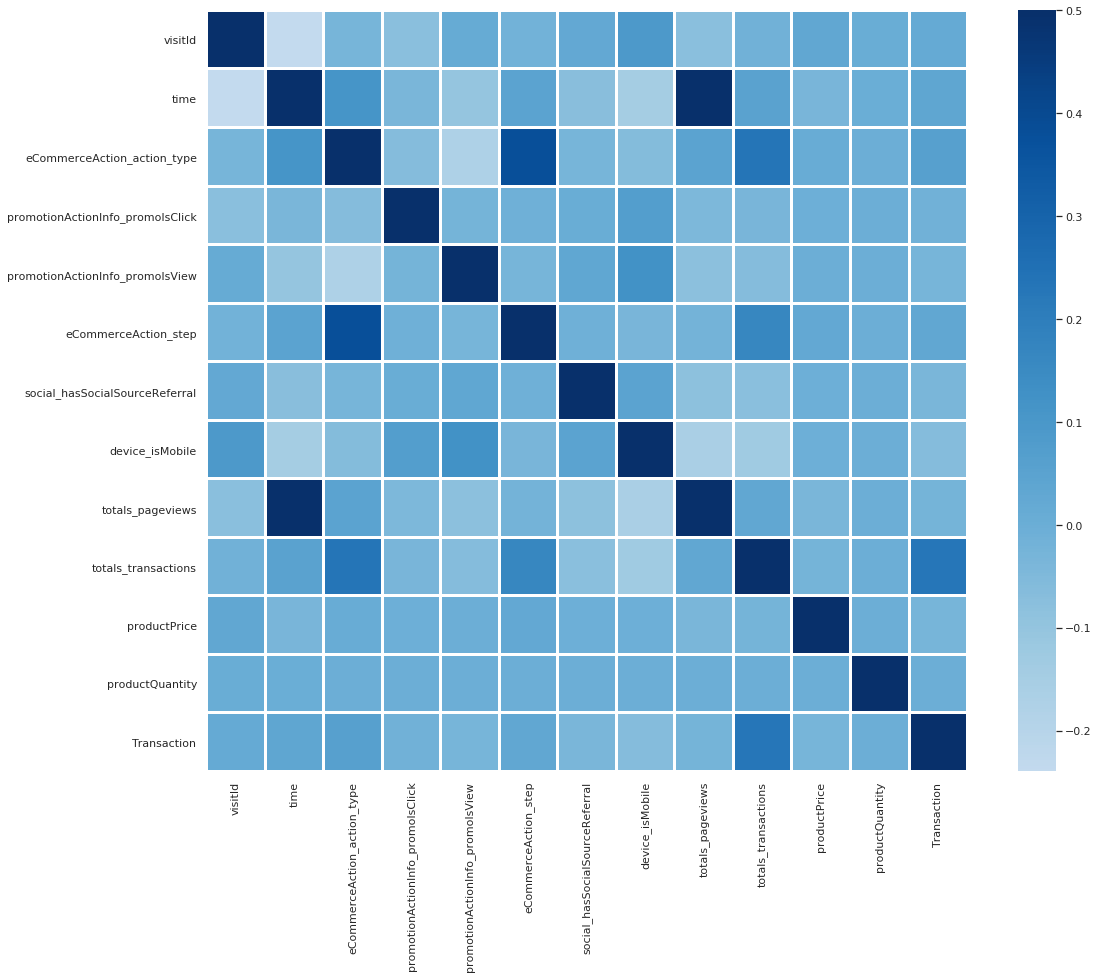

In [138]:
corr = df_trans.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr, vmax=0.5, center=0,
            square=True, linewidths=2, cmap='Blues')


### Construindo o modelo

Como dito vamos construi apenas um modelo simples então, temos

In [139]:
X = df_trans.drop(['fullVisitorId','visitId','Transaction'], axis=1).values()
y = df_trans.Transaction

In [144]:
std = StandardScaler()
X = std.fit_transform(X)

In [145]:
X_train, X_test, y_train, y_test  =   train_test_split(X, y, test_size=.3)

print( "Treinamento : ", X_train.shape, "Teste : ", X_test.shape )

Treinamento :  (5730380, 11) Teste :  (2455878, 11)


In [146]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

classifier= GaussianNB()
classifier=classifier.fit(X_train,y_train)

predictions=classifier.predict(X_test)


confusion_matrix(y_test,predictions)

array([[ 813863, 1545189],
       [   1117,   95709]])

In [147]:
accuracy_score(y_test, predictions)


0.37036530316245353

In [148]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.34      0.51   2359052
           1       0.06      0.99      0.11     96826

    accuracy                           0.37   2455878
   macro avg       0.53      0.67      0.31   2455878
weighted avg       0.96      0.37      0.50   2455878



Esse modelo não se saiu bem, talvez seja melhor tentar outro.

**Outro Modelo**

In [166]:
rf = tree.DecisionTreeClassifier()
rf = rf.fit(X_train,y_train)

In [167]:
predictions=rf.predict(X_test)


confusion_matrix(y_test,predictions)

array([[2358636,     416],
       [    514,   96312]])

In [168]:
accuracy_score(y_test, predictions)


0.9996213166940703

In [169]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2359052
           1       1.00      0.99      1.00     96826

    accuracy                           1.00   2455878
   macro avg       1.00      1.00      1.00   2455878
weighted avg       1.00      1.00      1.00   2455878



Um pouco melhor !